In [1]:
import numpy as np
import pandas as pd
#import pandas_profiling as pp
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, RandomizedSearchCV
import copy
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from collections import defaultdict
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, LinearSVC
from sklearn import svm, tree
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE

### Data Preprocessing 

##### Appliances Energy Dataset 

In [73]:
# Appliances Energy Dataset
df = pd.read_csv('energydata_complete.csv')

df = df.drop(columns = ['date'])

x = df[['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']]
y = df['Appliances']
xtrain_energy, xtest_energy, ytrain_energy, ytest_energy = train_test_split(x, y, test_size=0.3, random_state=0) # xtrain - 13814 obs, xtest - 5921 obs

# Categorizing the target variable
xtrain_energy['energy_high'] = np.where(xtrain_energy.Appliances > xtrain_energy.Appliances.median(),1,0)
xtest_energy['energy_high'] = np.where(xtest_energy.Appliances > xtrain_energy.Appliances.median(),1,0)

xtrain2 = xtrain_energy.iloc[:,1:-1]
xtest2 = xtest_energy.iloc[:,1:-1]

ytrain_app_energy = xtrain_energy.iloc[:,-1]
ytest_app_energy = xtest_energy.iloc[:,-1] # 0's and 1's

# Data Scaling - Standardization - z = (X-mu)/sigma
xtrain2 = (xtrain2-xtrain2.mean())/(xtrain2.std())
xtest2 = (xtest2-xtest2.mean())/(xtest2.std())

# Ten best suited features
# Removing all the features having correlations less than 0.06
# Removing T_out to avoid multicollinearity with T6
xtrain_app_energy = xtrain2.drop(columns = ['T1', 'T4', 'T5', 'T7', 'T8', 'T9', 'RH_3', 'RH_4', 'RH_5', 'RH_7', 'RH_9', 'T_out', 'Visibility', 'Tdewpoint', 'Press_mm_hg', 'rv1', 'rv2'])
xtest_app_energy = xtest2.drop(columns = ['T1', 'T4', 'T5', 'T7', 'T8', 'T9', 'RH_3', 'RH_4', 'RH_5', 'RH_7', 'RH_9', 'T_out', 'Visibility', 'Tdewpoint', 'Press_mm_hg', 'rv1', 'rv2'])
print(xtrain_app_energy.columns)

Index(['lights', 'RH_1', 'T2', 'RH_2', 'T3', 'T6', 'RH_6', 'RH_8', 'RH_out',
       'Windspeed'],
      dtype='object')


C:\Users\himaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\himaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


##### German Credit Dataset 

In [3]:
# German Credit Dataset
data = pd.read_csv('german_credit.csv',sep = ',')
print(data.isnull().values.sum()) #There are no missing values in any of the observations
data = data.rename(columns = {"default":"creditability"})
data.columns

0


Index(['creditability', 'account_check_status', 'duration_in_month',
       'credit_history', 'purpose', 'credit_amount', 'savings',
       'present_emp_since', 'installment_as_income_perc',
       'personal_status_sex', 'other_debtors', 'present_res_since', 'property',
       'age', 'other_installment_plans', 'housing', 'credits_this_bank', 'job',
       'people_under_maintenance', 'telephone', 'foreign_worker'],
      dtype='object')

In [4]:
data1 = data.copy()
data1.head(2)

,creditability,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes


In [5]:
# 0 = bad credit, 1 = good credit
data1.creditability.replace([0,1], [1,0], inplace=True)
data1.creditability.value_counts()
# Number of good credits = 700, Number of bad credits = 300

1    700
0    300
Name: creditability, dtype: int64

In [6]:
cont_vars = data1.select_dtypes(include=['int64']).drop(['creditability'],axis=1)
cont_vars = (cont_vars-cont_vars.min())/(cont_vars.max()-cont_vars.min())

In [7]:
cont_vars.columns

Index(['duration_in_month', 'credit_amount', 'installment_as_income_perc',
       'present_res_since', 'age', 'credits_this_bank',
       'people_under_maintenance'],
      dtype='object')

In [8]:
data2 = data1.copy()
data3 = cont_vars.copy()
obj_data = data2.select_dtypes(include=['object']).copy()
obj_data = pd.get_dummies(obj_data, prefix=['account', 'credit','purpose','savings','present_since','marital_status','debtors','property','other_plans','housing','job','telephone','foreign'])
obj_data.head()

,account_0 <= ... < 200 DM,account_< 0 DM,account_>= 200 DM / salary assignments for at least 1 year,account_no checking account,credit_all credits at this bank paid back duly,credit_critical account/ other credits existing (not at this bank),credit_delay in paying off in the past,credit_existing credits paid back duly till now,credit_no credits taken/ all credits paid back duly,purpose_(vacation - does not exist?),...,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_no,foreign_yes
0,0,1,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1
1,1,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,1
2,0,0,0,1,0,1,0,0,0,1,...,1,0,0,0,0,1,1,0,0,1
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [9]:
data3 = pd.concat([data1['creditability'],data3],axis=1)
data3.reset_index(drop=True, inplace=True)
obj_data.reset_index(drop=True, inplace=True)
df2 = pd.concat([data3,obj_data], axis=1)
df2.head(2)

,creditability,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_0 <= ... < 200 DM,account_< 0 DM,...,housing_own,housing_rent,job_management/ self-employed/ highly qualified employee/ officer,job_skilled employee / official,job_unemployed/ unskilled - non-resident,job_unskilled - resident,telephone_none,"telephone_yes, registered under the customers name",foreign_no,foreign_yes
0,1,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,0,1,...,1,0,0,1,0,0,0,1,0,1
1,0,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,1,0,...,1,0,0,1,0,0,1,0,0,1


In [10]:
df2.shape

(1000, 62)

In [11]:
df2['creditability'].value_counts() 
# Imbalanced classes, so there might be error in the prediction 
#accuracy because the minority class might complately ignored in favpr of majority class

1    700
0    300
Name: creditability, dtype: int64

In [10]:
train,test = train_test_split(df2,test_size=0.30,random_state=0) # train=700, test=300
xtrain = train.iloc[:,1:]
xtest = test.iloc[:,1:]

ytrain = train.iloc[:,0]
ytest = test.iloc[:,0]

In [13]:
xtrain.shape

(700, 61)

##### Handling Class imbalance using SMOTE 

In [11]:
# Getting rid of the Class-Imbalance problem using SMOTE
sm = SMOTE(ratio='auto')
xtrain1, ytrain1 = sm.fit_sample(xtrain, ytrain)

In [15]:
np.shape(xtrain1)

(972, 61)

### Algorithms

In [12]:
def cross_val(clf, xtrain, ytrain, ytest, ypred1, ypred):
    score1 = cross_val_score(clf, xtrain, ytrain, cv=10, scoring='accuracy')
    score2 = cross_val_score(clf, xtrain, ytrain, cv=10, scoring='precision')
    score3 = cross_val_score(clf, xtrain, ytrain, cv=10, scoring='recall')
    score4 = cross_val_score(clf, xtrain, ytrain, cv=10, scoring='roc_auc')
    print('Train Error: ', 1-accuracy_score(ytrain, ypred1))
    print('Test Error: ', 1-accuracy_score(ytest, ypred))
    print("CV Accuracy: %0.2f (+/- %0.2f)" % (score1.mean(), score1.std()))
    print("CV Precision: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std()))
    print("CV Recall: %0.2f (+/- %0.2f)" % (score3.mean(), score3.std()))
    print("CV roc_auc: %0.2f (+/- %0.2f)" % (score4.mean(), score4.std()))
    cm = confusion_matrix(ytest,ypred)
    print(cm)
    return

In [13]:
def auc_roc (ytest, ypred):
    fpr,tpr,roc_auc = dict(),dict(),dict()
    fpr, tpr, _ = roc_curve(ytest, ypred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw=2
    plt.plot(fpr, tpr, color='red',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return

In [14]:
def logistic_reg(xtrain, ytrain, xtest, ytest):
    #cv = StratifiedKFold(n_splits=12)
    #sizes = np.linspace(0.3, 1.0, 10)
    logitr = LogisticRegression(solver='lbfgs')
    logist_model = logitr.fit(xtrain, ytrain)
    #model = learning_curve(logitr,cv=cv,scoring='f1_weighted',train_sizes=sizes,n_jobs=4)
    #model.fit(xtrain,ytrain)
    #model.show()
    ypred1 = logist_model.predict(xtrain)
    ypred = logist_model.predict(xtest)
    auc_roc(ytest,ypred)
    print(classification_report(ytest,ypred))
    cross_val(logist_model, xtrain, ytrain, ytest, ypred1, ypred)
    return

In [15]:
def linear_svm(xtrain, ytrain, xtest, ytest, C): 
    svc_model = svm.LinearSVC(C=C, class_weight="balanced",dual=False).fit(xtrain, ytrain)
    ypred1 = svc_model.predict(xtrain)
    ypred = svc_model.predict(xtest)
    cross_val(svc_model, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

In [16]:
def svm_kernel_poly(xtrain, ytrain, xtest, ytest, degree): 
    svc_model = svm.SVC(kernel='poly',degree=degree,gamma='auto',probability=True,C=1,class_weight="balanced").fit(xtrain, ytrain)
    ypred1 = svc_model.predict(xtrain)
    ypred = svc_model.predict(xtest)
    cross_val(svc_model, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

In [17]:
def svm_kernel_rbf(xtrain, ytrain, xtest, ytest, gamma): 
    svc_model = svm.SVC(kernel='rbf',gamma=gamma,probability=True,C=1,class_weight="balanced").fit(xtrain, ytrain)
    ypred1 = svc_model.predict(xtrain)
    ypred = svc_model.predict(xtest)
    cross_val(svc_model, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

In [18]:
def decision_tree(xtrain, ytrain, xtest, ytest):
    tree_model = tree.DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=5).fit(xtrain, ytrain)
    ypred1 = tree_model.predict(xtrain)
    ypred = tree_model.predict(xtest)
    cross_val(tree_model, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

In [19]:
def decision_tree_entropy(xtrain,ytrain,xtest,ytest):
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',min_samples_split=10, min_samples_leaf=5,max_depth=3).fit(xtrain, ytrain)
    ypred1 = tree_model.predict(xtrain)
    ypred = tree_model.predict(xtest)
    cross_val(tree_model, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

In [20]:
def random_forest(xtrain, ytrain, xtest, ytest):
    randomforest = RandomForestClassifier().fit(xtrain, ytrain)
    ypred1 = randomforest.predict(xtrain)
    ypred = randomforest.predict(xtest)
    cross_val(randomforest, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

In [21]:
def gradient_boosting(xtrain, ytrain, xtest, ytest):  
    gb = GradientBoostingClassifier().fit(xtrain, ytrain)
    ypred1 = gb.predict(xtrain)
    ypred = gb.predict(xtest)
    cross_val(gb, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

In [22]:
def ada_boost(xtrain, ytrain, xtest, ytest):  
    adb = AdaBoostClassifier().fit(xtrain, ytrain)
    ypred1 = adb.predict(xtrain)
    ypred = adb.predict(xtest)
    cross_val(adb, xtrain, ytrain, ytest, ypred1, ypred)
    auc_roc(ytest,ypred)
    return

In [114]:
def learning_curves(estimator, title, xtrain, ytrain, ylim=None, cv=10, scoring='accuracy', obj_line=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, xtrain, ytrain, cv=10, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="red", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")
    if obj_line:
        plt.axhline(y=obj_line, color='blue')
    plt.legend(loc="best")
    return plt

### Implementation 

#### Naive-Baye's 

##### Naive Baye's - Appliances Data 

Train Error:  0.31989286231359493
Naive-Bayes accuracy :  0.6782638067893937


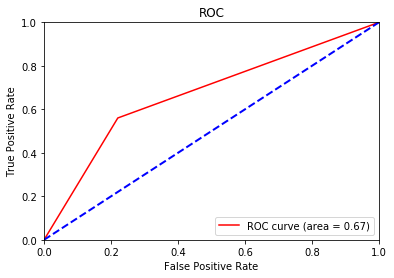

In [117]:
# Naive-Baye's - Appliances Data
gnb = GaussianNB()
pred = gnb.fit(xtrain_app_energy, ytrain_app_energy).predict(xtest_app_energy)
pred1 = gnb.fit(xtrain_app_energy, ytrain_app_energy).predict(xtrain_app_energy)
print("Train Error: ", 1-accuracy_score(ytrain_app_energy,pred1, normalize=True))
print("Naive-Bayes accuracy : ",accuracy_score(ytest_app_energy, pred, normalize = True))
auc_roc(ytest_app_energy,pred)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

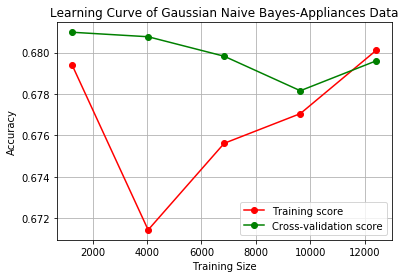

In [115]:
learning_curves(GaussianNB(),'Learning Curve of Gaussian Naive Bayes-Appliances Data', xtrain_app_energy,ytrain_app_energy)

#####  Naive Baye's - German Credit Data 

Train Error:  0.25
Naive-Bayes accuracy :  0.7033333333333334


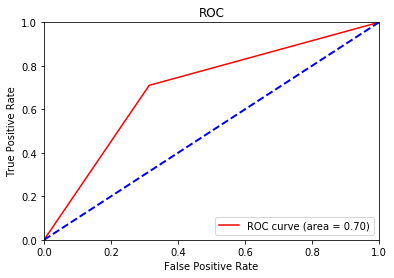

In [120]:
# Naive-Baye's - Unbalanced Data
gnb = GaussianNB()
pred = gnb.fit(xtrain, ytrain).predict(xtest)
pred1 = gnb.fit(xtrain,ytrain).predict(xtrain)
print("Train Error: ", 1-accuracy_score(ytrain,pred1, normalize=True))
print("Naive-Bayes accuracy : ",accuracy_score(ytest, pred, normalize = True))
auc_roc(ytest,pred)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

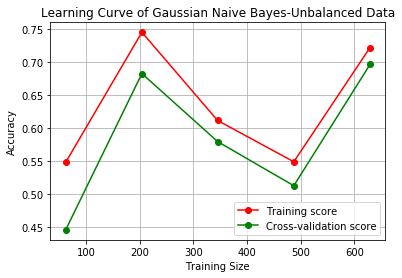

In [35]:
learning_curves(GaussianNB(),'Learning Curve of Gaussian Naive Bayes-Unbalanced Data', xtrain,ytrain)

Train Error:  0.25411522633744854
Naive-Bayes accuracy :  0.6466666666666666


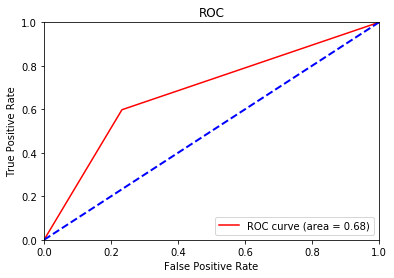

In [121]:
# Naive-Baye's - Balanced Data
gnb = GaussianNB()
pred = gnb.fit(xtrain1, ytrain1).predict(xtest)
pred1 = gnb.fit(xtrain1,ytrain1).predict(xtrain1)
print("Train Error: ", 1-accuracy_score(ytrain1,pred1, normalize=True))
print("Naive-Bayes accuracy : ",accuracy_score(ytest, pred, normalize = True))
auc_roc(ytest,pred)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

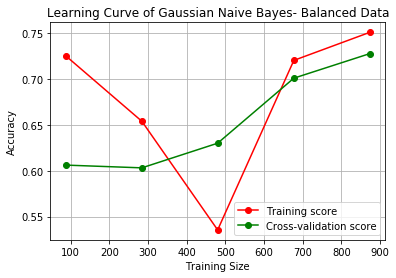

In [39]:
learning_curves(GaussianNB(),'Learning Curve of Gaussian Naive Bayes- Balanced Data', xtrain1,ytrain1)

#### Logistic Regression 

#####  Logistic Regression - Appliances Data 

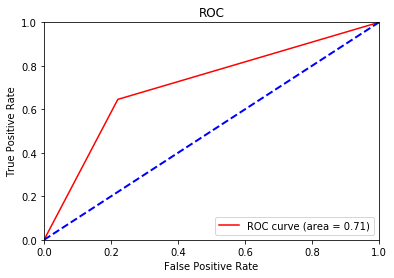

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      3183
           1       0.72      0.65      0.68      2738

    accuracy                           0.72      5921
   macro avg       0.72      0.71      0.71      5921
weighted avg       0.72      0.72      0.72      5921

Train Error:  0.26907485159982625
Test Error:  0.28221584191859483
CV Accuracy: 0.73 (+/- 0.01)
CV Precision: 0.72 (+/- 0.01)
CV Recall: 0.65 (+/- 0.01)
CV roc_auc: 0.80 (+/- 0.01)
[[2482  701]
 [ 970 1768]]


In [78]:
logistic_reg(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

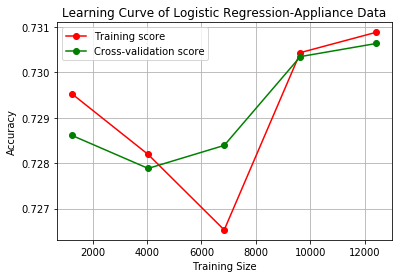

In [79]:
learning_curves(LogisticRegression(solver='lbfgs'),'Learning Curve of Logistic Regression-Appliance Data', xtrain_app_energy, ytrain_app_energy)

#####  Logistic Regression - German Credit Data 

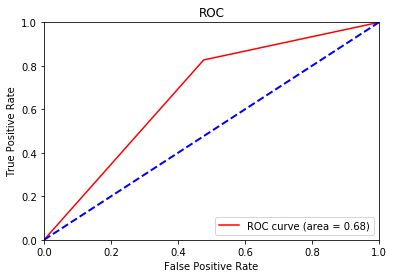

              precision    recall  f1-score   support

           0       0.55      0.52      0.54        86
           1       0.81      0.83      0.82       214

    accuracy                           0.74       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.74      0.74      0.74       300

Train Error:  0.19999999999999996
Test Error:  0.26
CV Accuracy: 0.75 (+/- 0.04)
CV Precision: 0.79 (+/- 0.03)
CV Recall: 0.87 (+/- 0.06)
CV roc_auc: 0.79 (+/- 0.06)
[[ 45  41]
 [ 37 177]]


In [253]:
logistic_reg(xtrain, ytrain, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

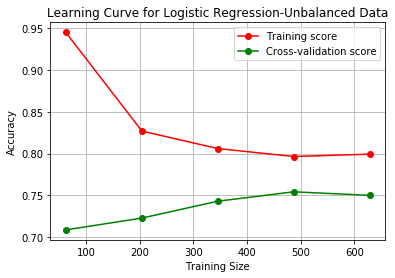

In [40]:
learning_curves(LogisticRegression(solver='lbfgs'),'Learning Curve for Logistic Regression-Unbalanced Data', xtrain,ytrain)

In [ ]:
# The two diagnostic tools that help in the interpretation of probabilistic forecast for binary (two-class) classification 
#    predictive modeling problems are ROC Curves and Precision-Recall curves

# ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model 
#    using different probability thresholds
# Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a 
#    predictive model using different probability thresholds
# ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves 
#    are appropriate for imbalanced datasets

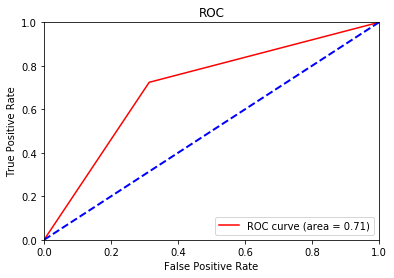

              precision    recall  f1-score   support

           0       0.50      0.69      0.58        86
           1       0.85      0.72      0.78       214

    accuracy                           0.71       300
   macro avg       0.68      0.71      0.68       300
weighted avg       0.75      0.71      0.72       300

Train Error:  0.2098765432098766
Test Error:  0.2866666666666666
CV Accuracy: 0.75 (+/- 0.05)
CV Precision: 0.77 (+/- 0.05)
CV Recall: 0.72 (+/- 0.09)
CV roc_auc: 0.83 (+/- 0.06)
[[ 59  27]
 [ 59 155]]


In [255]:
# Logistic Regression - balanced data
logistic_reg(xtrain1, ytrain1, xtest, ytest)
# Accuracy = 75%
# Error rate = 25%

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

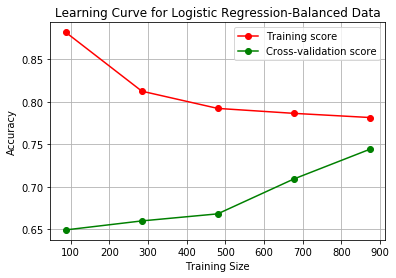

In [41]:
learning_curves(LogisticRegression(solver='lbfgs'),'Learning Curve for Logistic Regression-Balanced Data', xtrain1,ytrain1)

#### SVM 

#####  SVM - Appliances Data 

Train Error:  0.26697553206891556
Test Error:  0.27816247255531157
CV Accuracy: 0.73 (+/- 0.01)
CV Precision: 0.70 (+/- 0.01)
CV Recall: 0.71 (+/- 0.01)
CV roc_auc: 0.80 (+/- 0.01)
[[2361  822]
 [ 825 1913]]


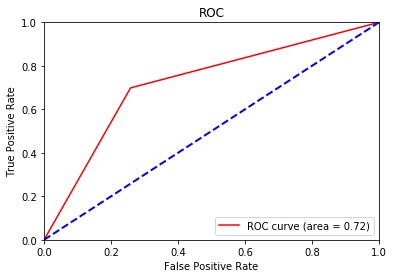

In [84]:
linear_svm(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy, 1)

C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

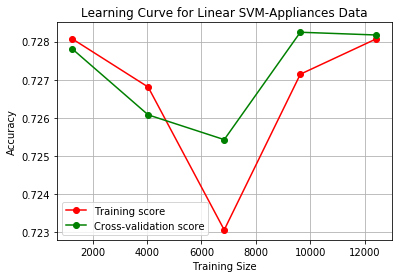

In [81]:
learning_curves(svm.LinearSVC(),'Learning Curve for Linear SVM-Appliances Data', xtrain_app_energy,ytrain_app_energy)

Train Error:  0.2787027653105545
Test Error:  0.2705624049991555
CV Accuracy: 0.72 (+/- 0.01)
CV Precision: 0.72 (+/- 0.01)
CV Recall: 0.62 (+/- 0.01)
CV roc_auc: 0.78 (+/- 0.01)
[[2561  622]
 [ 980 1758]]


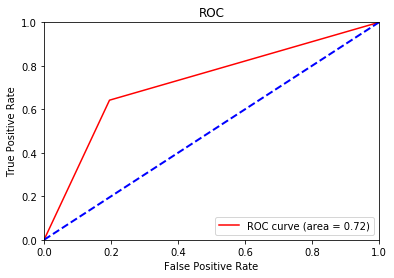

In [85]:
svm_kernel_poly(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy, 2)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

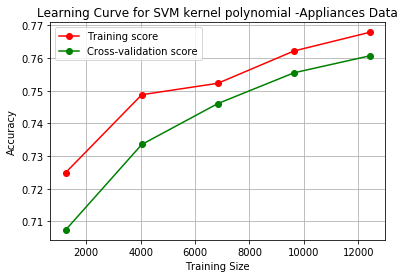

In [86]:
learning_curves(svm.SVC(kernel = 'poly',gamma='scale'),'Learning Curve for SVM kernel polynomial -Appliances Data', xtrain_app_energy,ytrain_app_energy)

#####  SVM - German Credit Data 

In [ ]:
# The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’
# and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples 
# selected by the model as support vectors.

# The C parameter trades off misclassification of training examples against simplicity of the decision surface. 
# A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly by giving
# the model freedom to select more samples as support vectors.

Train Error:  0.25
Test Error:  0.30000000000000004
CV Accuracy: 0.70 (+/- 0.06)
CV Precision: 0.83 (+/- 0.03)
CV Recall: 0.72 (+/- 0.08)
CV roc_auc: 0.79 (+/- 0.07)
[[ 60  26]
 [ 64 150]]


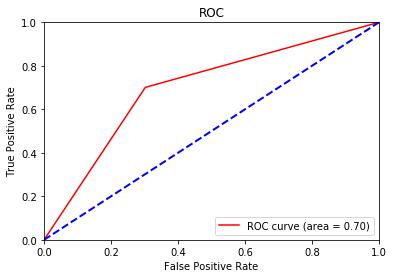

In [256]:
# Linear SVM - unbalanced data
linear_svm(xtrain, ytrain, xtest, ytest, 1)
# Accuracy = 70%

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

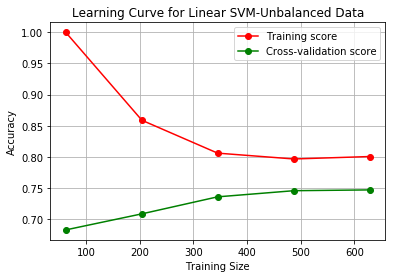

In [44]:
learning_curves(svm.LinearSVC(),'Learning Curve for Linear SVM-Unbalanced Data', xtrain,ytrain)

Train Error:  0.21399176954732513
Test Error:  0.29666666666666663
CV Accuracy: 0.76 (+/- 0.05)
CV Precision: 0.77 (+/- 0.05)
CV Recall: 0.73 (+/- 0.09)
CV roc_auc: 0.83 (+/- 0.06)
[[ 59  27]
 [ 62 152]]


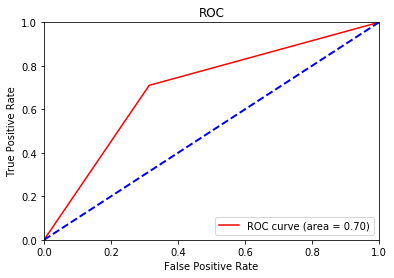

In [257]:
# Linear SVM - balanced data
linear_svm(xtrain1, ytrain1, xtest, ytest, 1)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

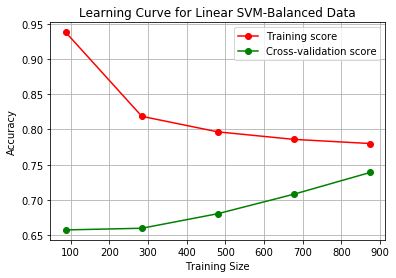

In [46]:
learning_curves(svm.LinearSVC(),'Learning Curve for Linear SVM-Balanced Data', xtrain1,ytrain1)

Train Error:  0.33571428571428574
Test Error:  0.33999999999999997
CV Accuracy: 0.64 (+/- 0.08)
CV Precision: 0.87 (+/- 0.04)
CV Recall: 0.56 (+/- 0.11)
CV roc_auc: 0.78 (+/- 0.05)
[[ 74  12]
 [ 90 124]]


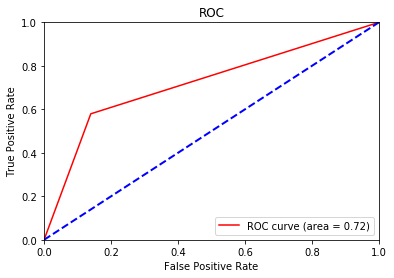

In [258]:
# Kernel = polynomial of degree 2 - unbalanced data
svm_kernel_poly(xtrain, ytrain, xtest, ytest, 2)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

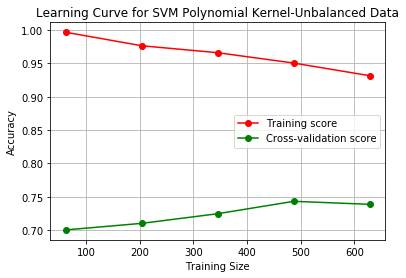

In [59]:
learning_curves(svm.SVC(kernel = 'poly',gamma='scale'),'Learning Curve for SVM Polynomial Kernel-Unbalanced Data', xtrain,ytrain)

Train Error:  0.2510288065843621
Test Error:  0.32666666666666666
CV Accuracy: 0.73 (+/- 0.05)
CV Precision: 0.79 (+/- 0.05)
CV Recall: 0.62 (+/- 0.10)
CV roc_auc: 0.81 (+/- 0.06)
[[ 66  20]
 [ 78 136]]


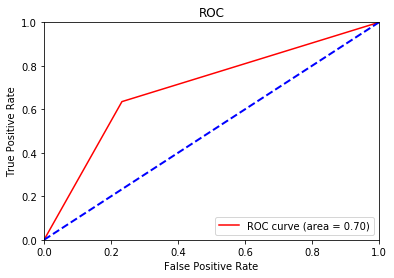

In [259]:
# Kernel = polynomial of degree 2 - balanced data
svm_kernel_poly(xtrain1, ytrain1, xtest, ytest, 2)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

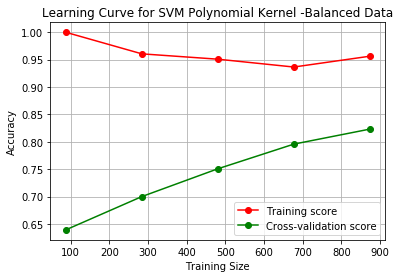

In [58]:
learning_curves(svm.SVC(kernel = 'poly',gamma='scale'),'Learning Curve for SVM Polynomial Kernel -Balanced Data', xtrain1,ytrain1)

Train Error:  0.0014285714285714457
Test Error:  0.2766666666666666
CV Accuracy: 0.70 (+/- 0.02)
CV Precision: 0.70 (+/- 0.01)
CV Recall: 0.99 (+/- 0.02)
CV roc_auc: 0.74 (+/- 0.08)
[[  8  78]
 [  5 209]]


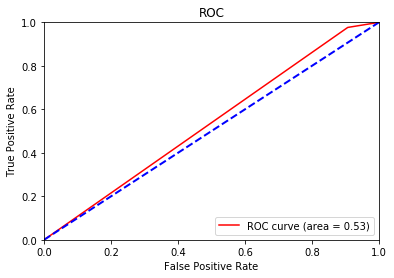

In [260]:
# Kernel = rbf, gamma=0.7 - unbalanced data
svm_kernel_rbf(xtrain, ytrain, xtest, ytest, 0.7)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

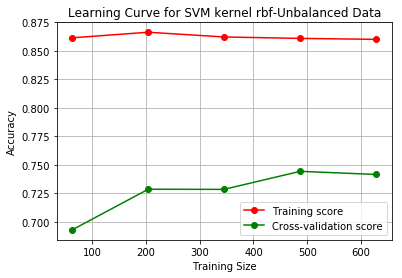

In [57]:
learning_curves(svm.SVC(kernel = 'rbf',gamma = 'scale', degree=3),'Learning Curve for SVM kernel rbf-Unbalanced Data', xtrain,ytrain)

Train Error:  0.0010288065843621075
Test Error:  0.2633333333333333
CV Accuracy: 0.92 (+/- 0.08)
CV Precision: 0.90 (+/- 0.12)
CV Recall: 0.98 (+/- 0.02)
CV roc_auc: 0.97 (+/- 0.03)
[[ 12  74]
 [  5 209]]


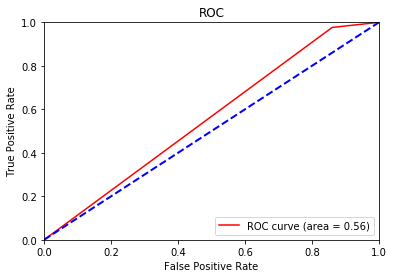

In [261]:
# Kernel = rbf, gamma=0.7 - balanced data
svm_kernel_rbf(xtrain1, ytrain1, xtest, ytest, 0.7)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

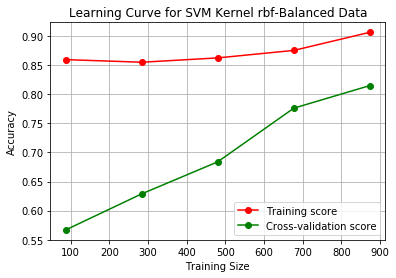

In [60]:
learning_curves(svm.SVC(kernel = 'rbf',gamma = 'scale', degree=3),'Learning Curve for SVM Kernel rbf-Balanced Data', xtrain1,ytrain1)

In [283]:
# Finding the best value for each of gamma,degree,C - SVM without polynomial Kernel
tuned_parameters = {'C': [1, 10, 100,500, 1000], 'kernel': ['linear','rbf'],\
                    'C': [1, 10, 100,500, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']}
svm_model= SVC()
model_svm = RandomizedSearchCV(svm_model, tuned_parameters,cv=10,scoring='accuracy',n_iter=20)
model_svm.fit(xtrain1, ytrain1)
print(model_svm.best_score_)
print(model_svm.best_params_)
#ypred= model_svm.predict(xtest)
#print(metrics.accuracy_score(ypred,ytest))
#print(metrics.classification_report(ytest,ypred))

0.9166666666666666
{'kernel': 'rbf', 'gamma': 1, 'C': 500}


C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [107]:
# Finding the best value for each of gamma,degree,C - SVM with Polynomial Kernel
tuned_parameters = {'C': [1, 10, 100,500, 1000], 'kernel': ['linear','rbf'],\
                    'C': [1, 10, 100,500, 1000], 'gamma': [1,0.1,0.01,0.001, 0.0001], 'kernel': ['rbf'],\
                    'degree': [2,3,4,5,6] , 'C':[1,10,100,500,1000] , 'kernel':['poly']}
svm_model= SVC()
model_svm = RandomizedSearchCV(svm_model, tuned_parameters,cv=10,scoring='accuracy',n_iter=20)
model_svm.fit(xtrain1, ytrain1)
print(model_svm.best_score_)
print(model_svm.best_params_)

0.8600823045267489
{'kernel': 'poly', 'gamma': 0.1, 'degree': 6, 'C': 500}


C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


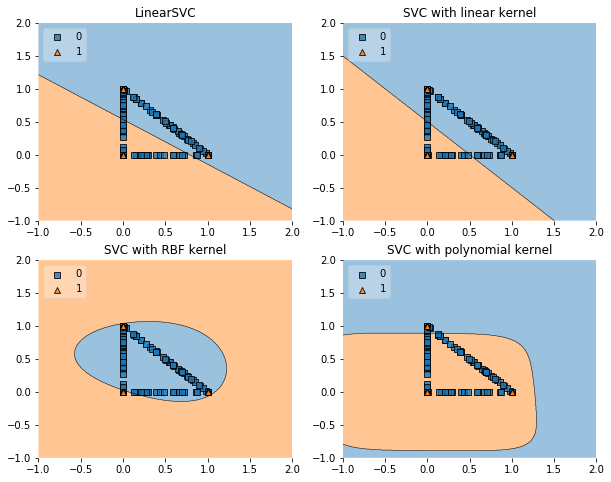

In [286]:
X = xtrain1[:, 7:9]
y = ytrain1

clf1 = LinearSVC(C=1)
clf2 = SVC(kernel='linear', C=1)
clf3 = SVC(kernel='rbf', gamma=1, C=500)
clf4 = SVC(kernel='poly', gamma=0.1, degree=6, C=1)

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

labels = ['LinearSVC','SVC with linear kernel','SVC with RBF kernel','SVC with polynomial kernel']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4],labels,itertools.product([0, 1],repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y,clf=clf, legend=2)
    plt.title(lab)

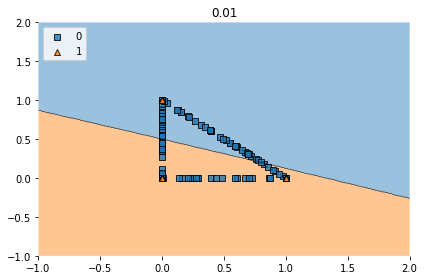

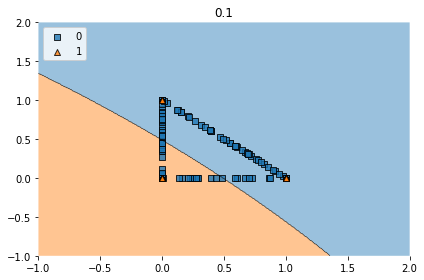

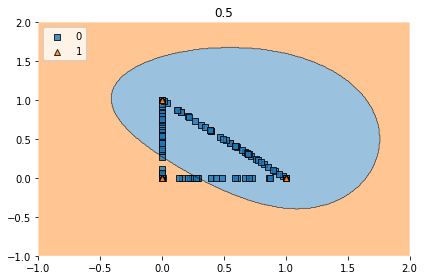

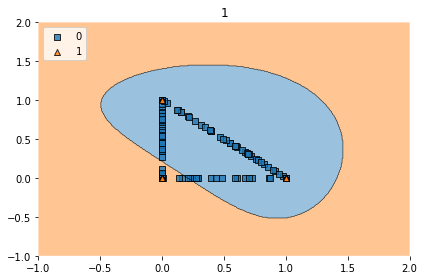

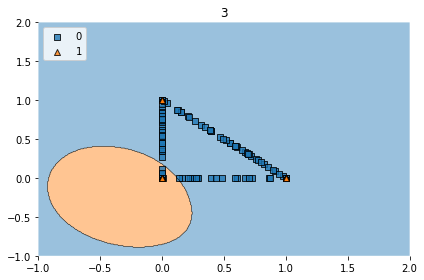

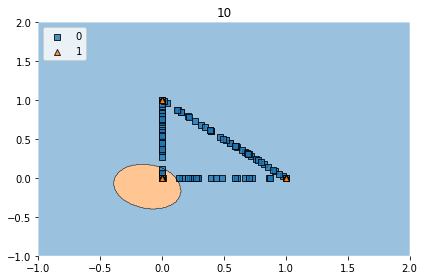

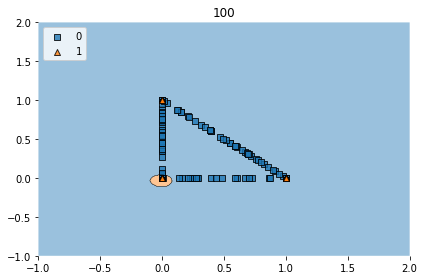

In [150]:
gammas = [0.01,0.1,0.5,1,3,10,100]
for gamma in gammas:
    svm = SVC(kernel='rbf', random_state=0, gamma=gamma, C=1).fit(X,y)
    plot_decision_regions(X, y, clf=svm)
    plt.title(gamma)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

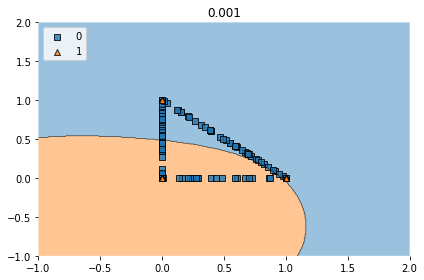

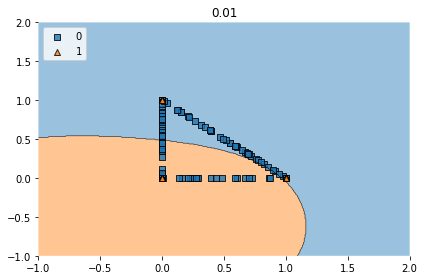

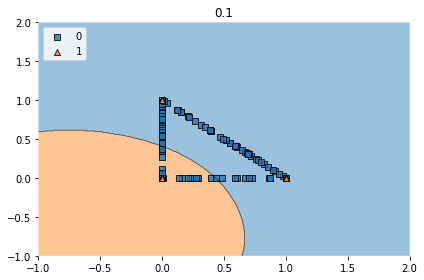

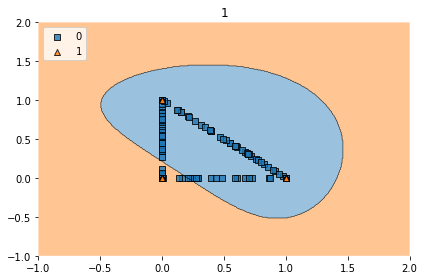

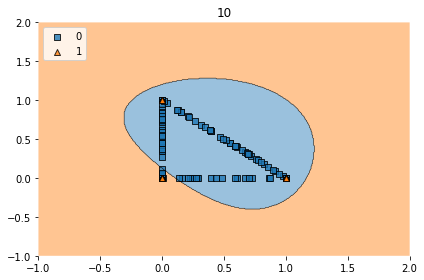

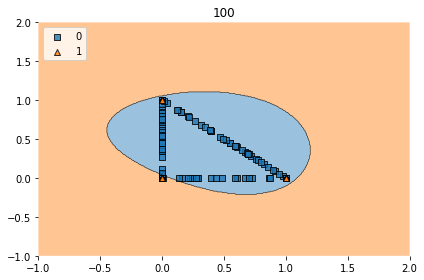

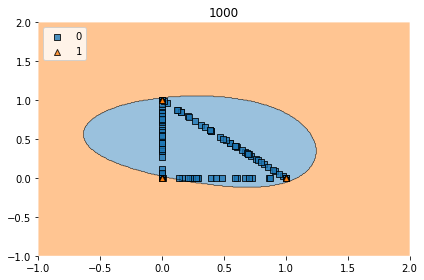

In [151]:
cs = [0.001,0.01,0.1,1,10,100,1000]
for c in cs:
    svm = SVC(kernel='rbf', random_state=0,gamma = 1, C=c).fit(X,y)
    plot_decision_regions(X, y, clf=svm)
    plt.title(c)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


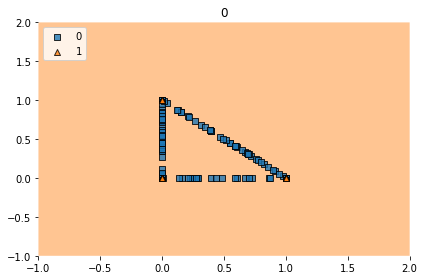

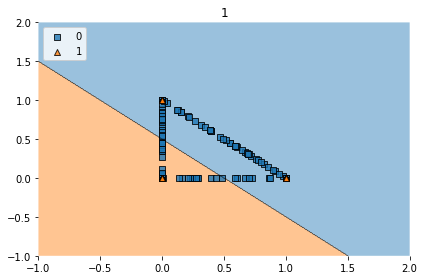

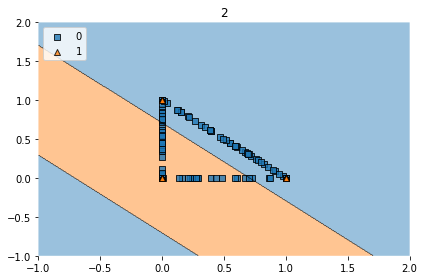

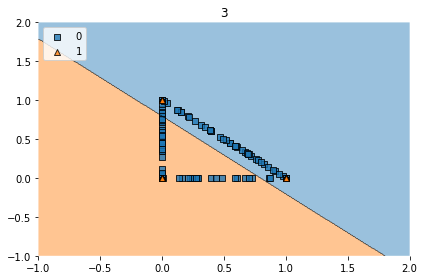

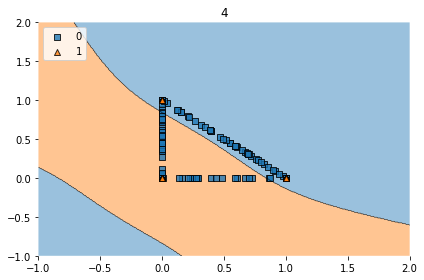

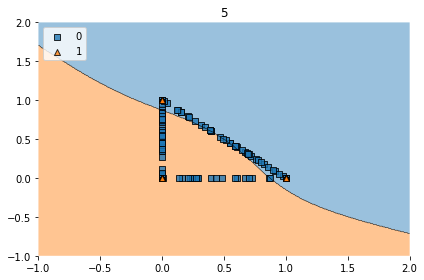

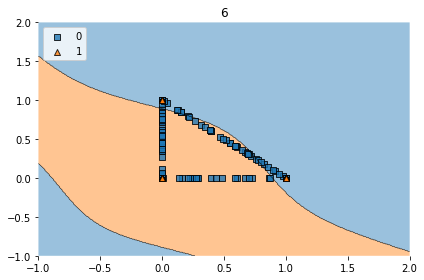

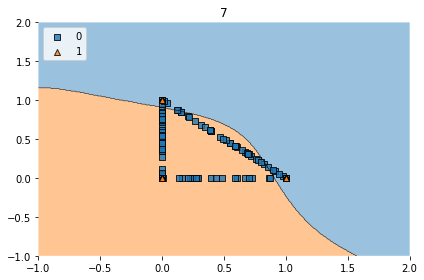

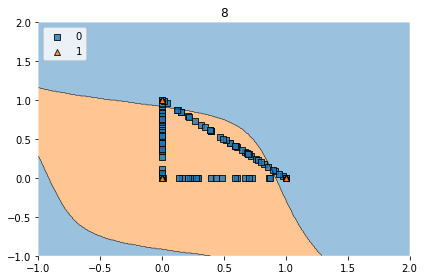

In [146]:
degree = [0,1,2,3,4,5,6,7,8]
for d in degree:
    svm = SVC(kernel='poly', random_state=0, gamma=1, C=1, degree=d).fit(X,y)
    plot_decision_regions(X, y, clf=svm)
    plt.title(d)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [110]:
X = xtrain1[:, 7:9]
y = ytrain1

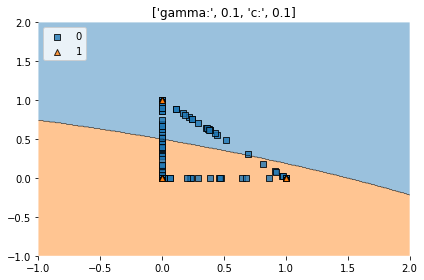

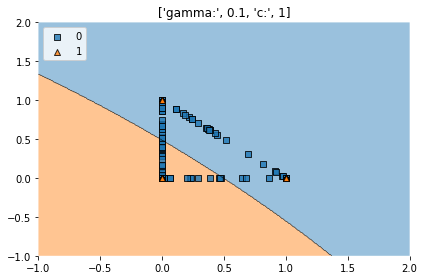

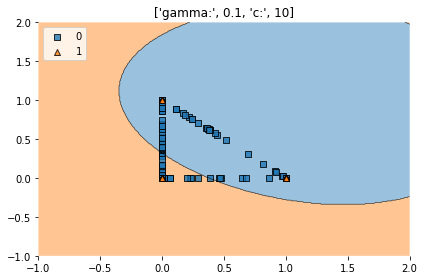

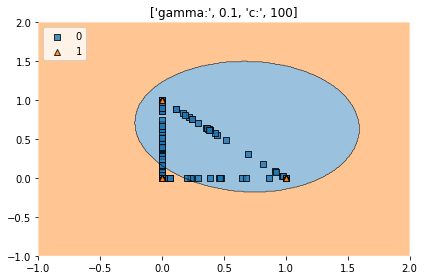

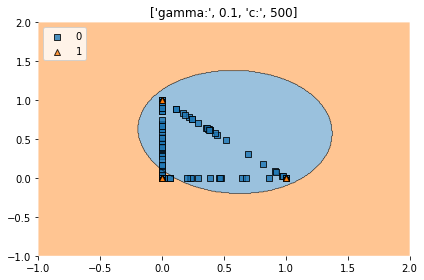

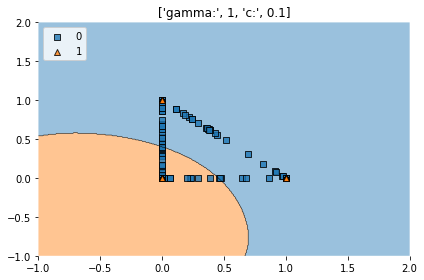

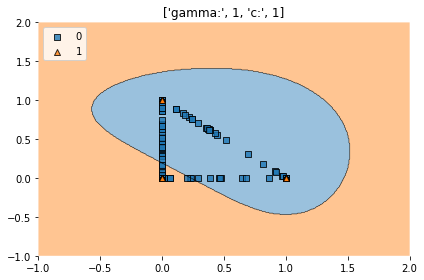

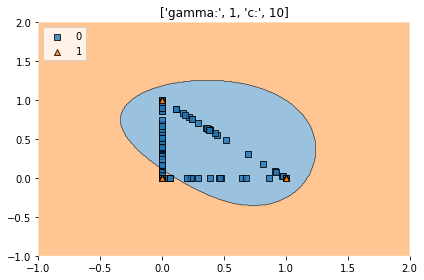

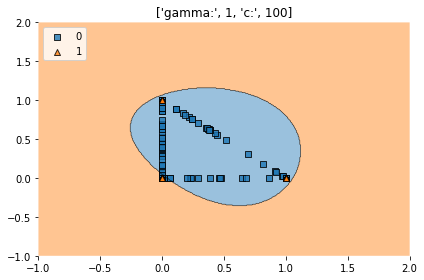

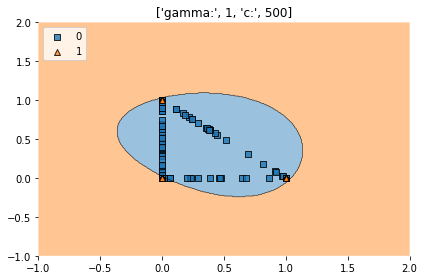

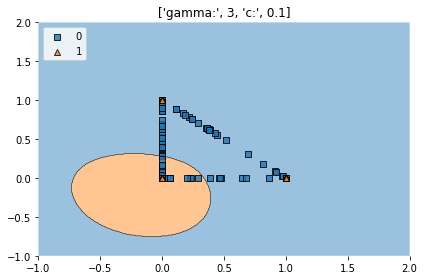

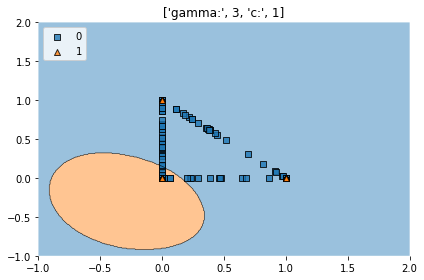

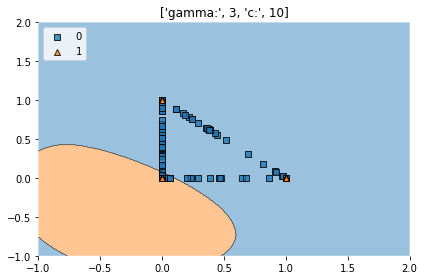

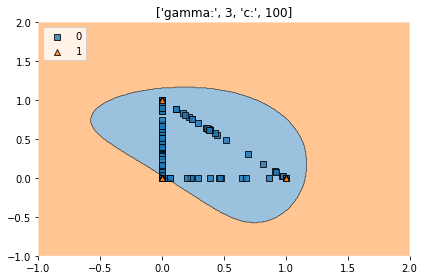

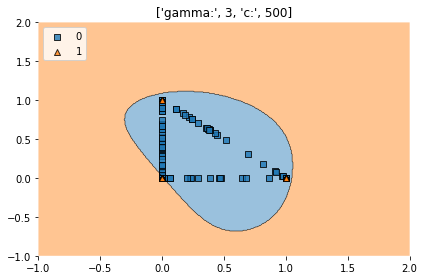

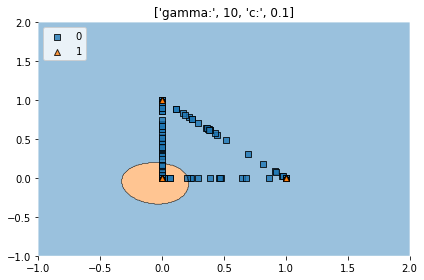

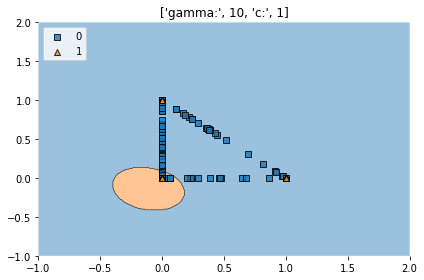

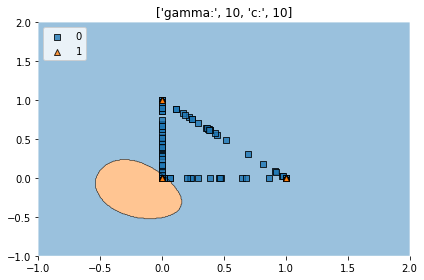

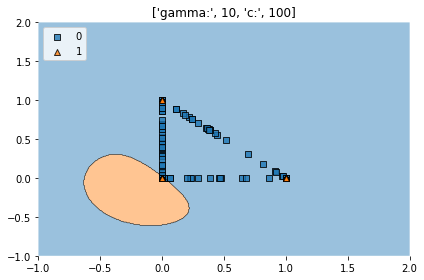

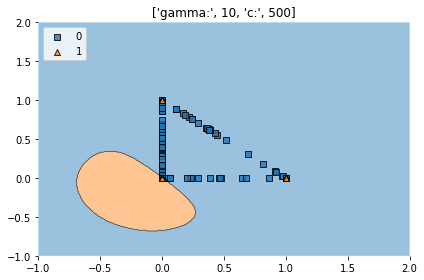

In [111]:
gammas = [0.1,1,3,10]
cs = [0.1,1,10,100,500]
#degree = [0,1,3,5,6]
for gamma in gammas:
    for c in cs:
        #for d in degree:
        svm = SVC(kernel='rbf', random_state=0, gamma=gamma, C=c).fit(X,y)
        plot_decision_regions(X, y, clf=svm)
        label = ['gamma:',gamma,'c:',c]
        plt.title(label)
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


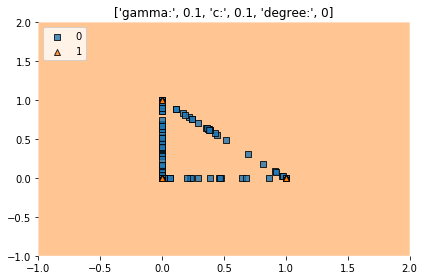

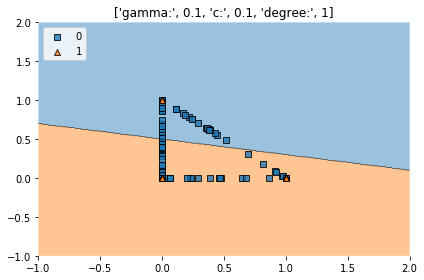

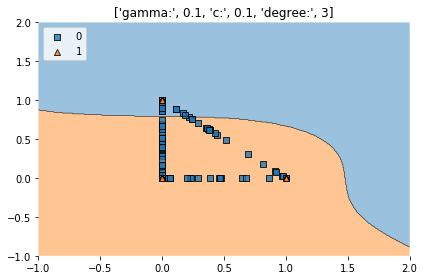

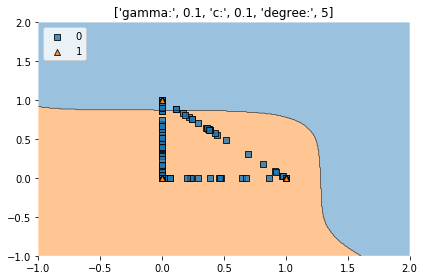

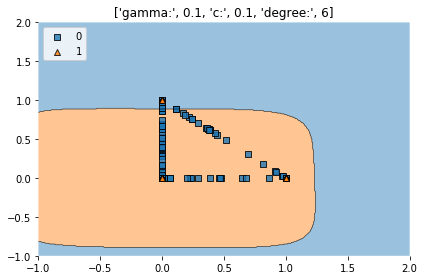

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


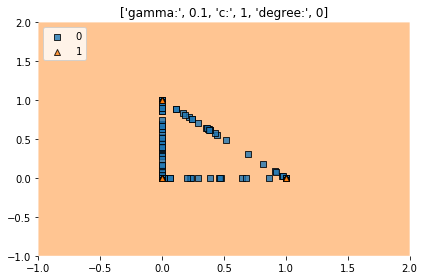

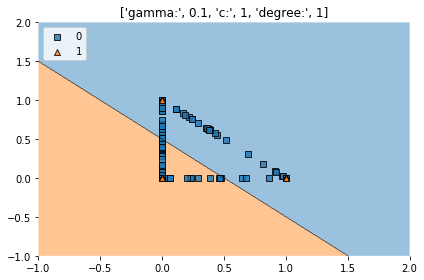

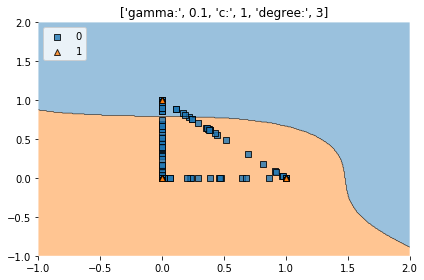

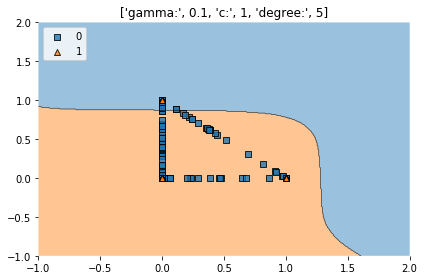

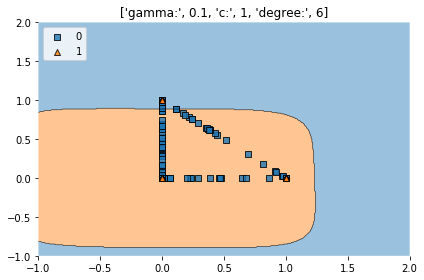

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


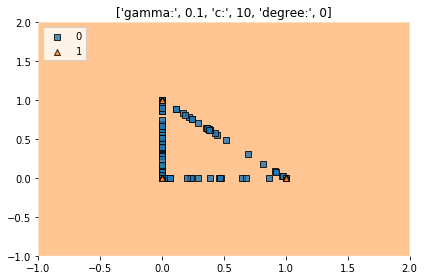

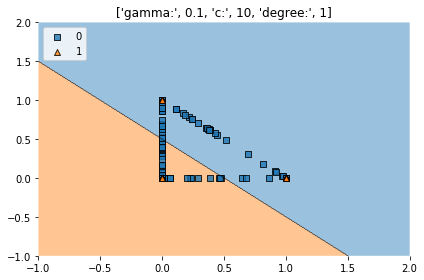

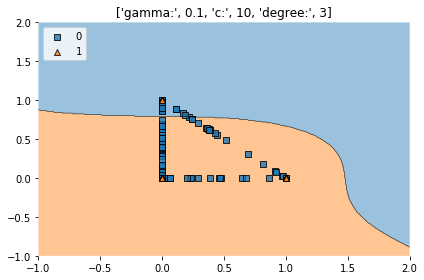

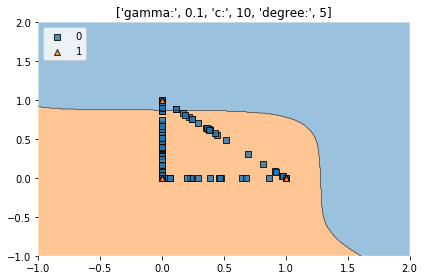

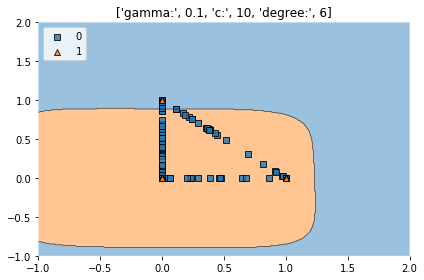

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


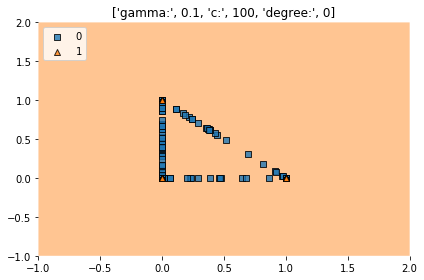

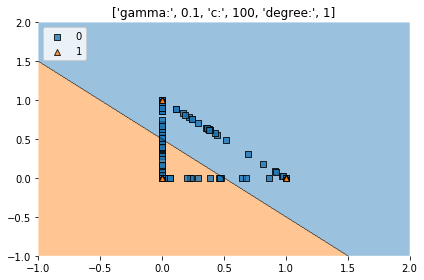

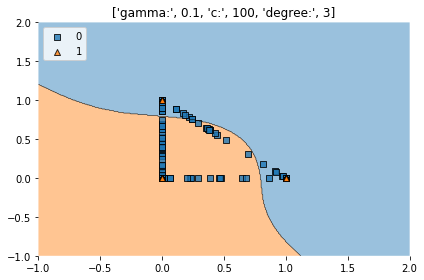

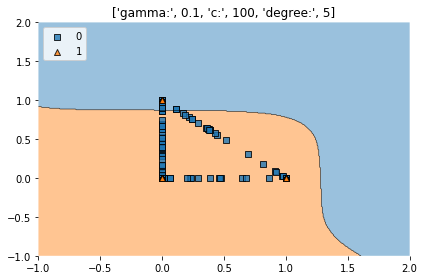

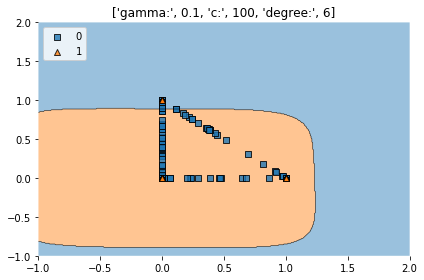

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


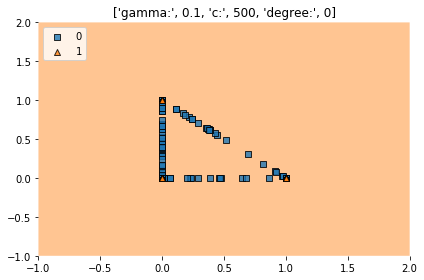

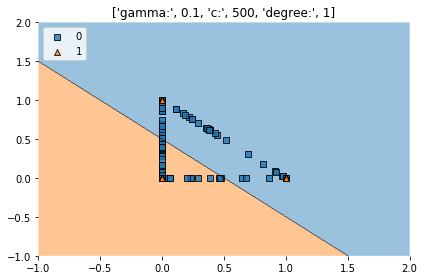

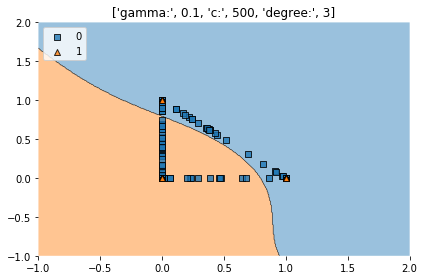

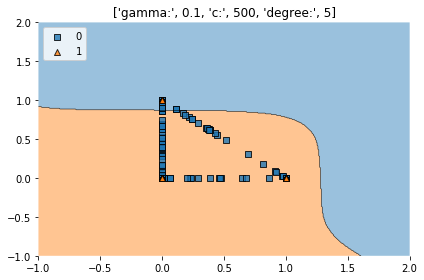

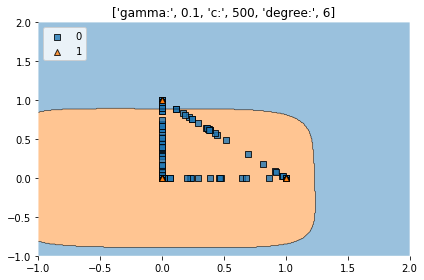

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


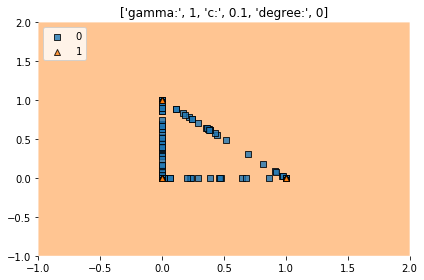

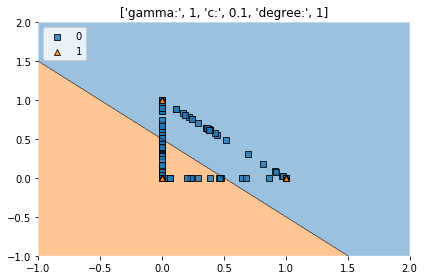

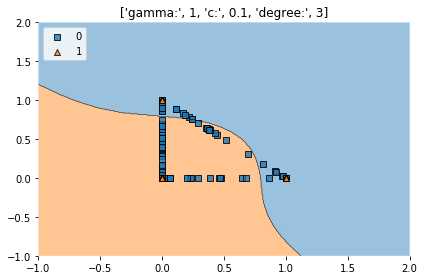

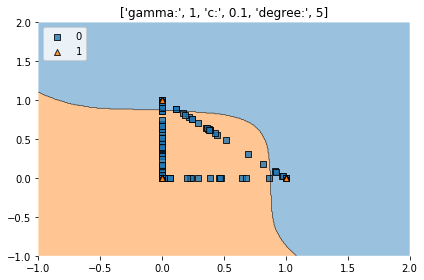

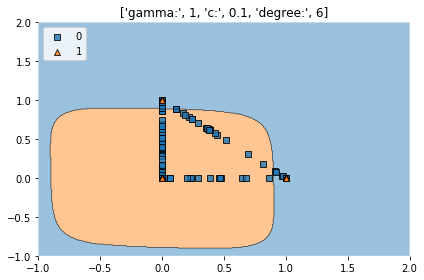

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


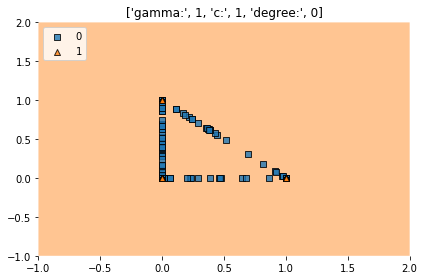

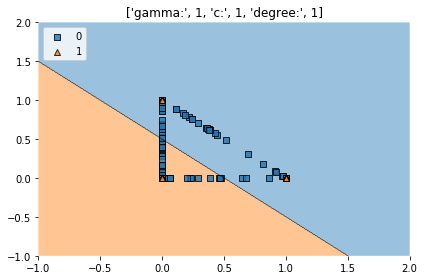

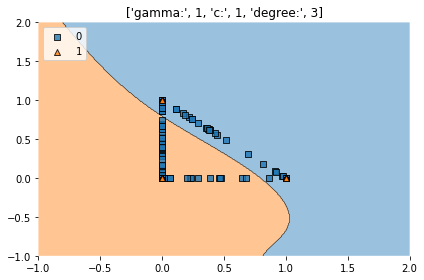

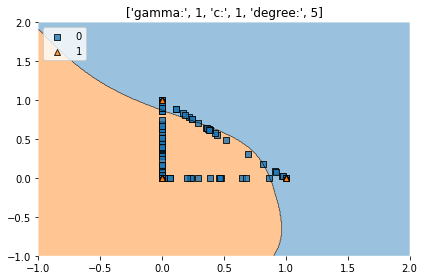

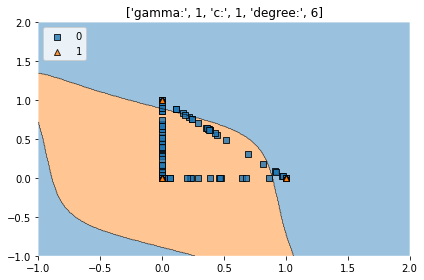

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


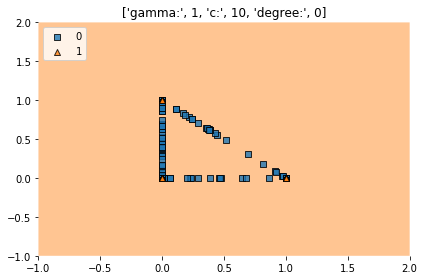

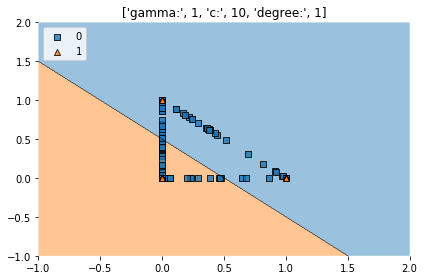

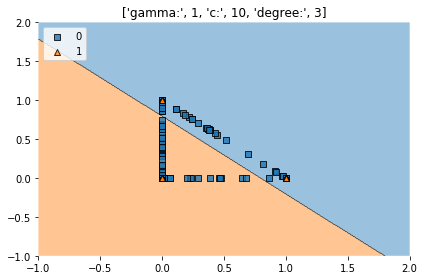

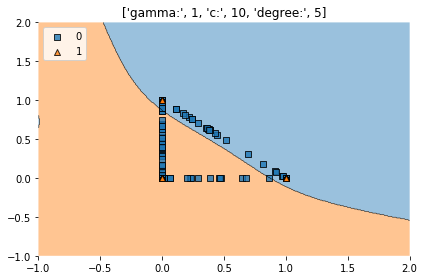

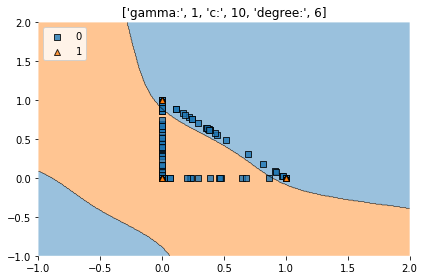

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


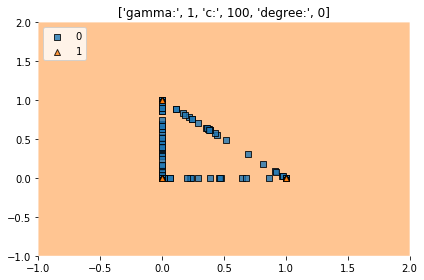

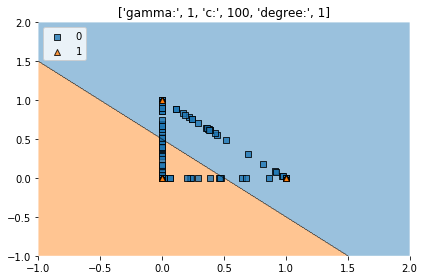

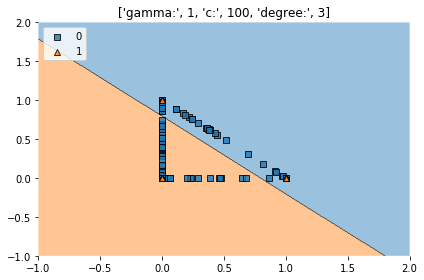

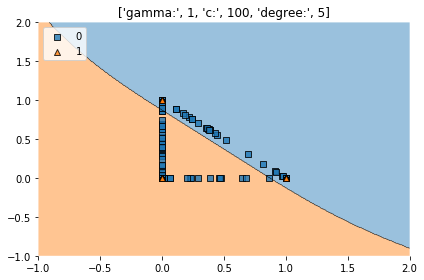

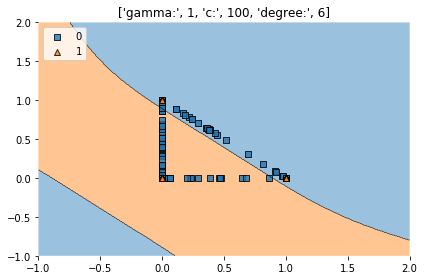

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


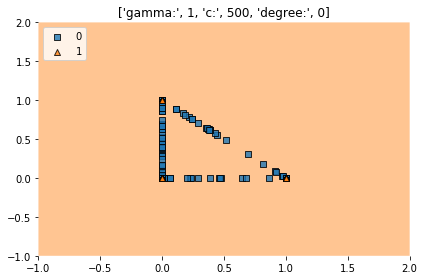

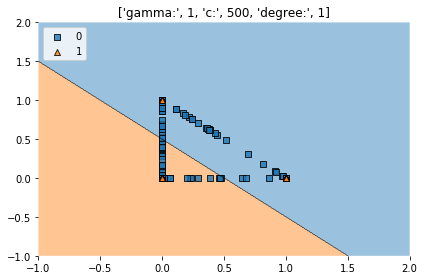

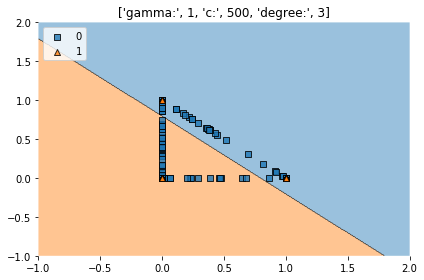

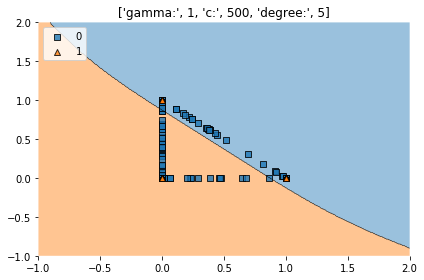

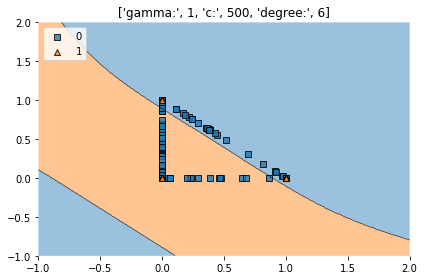

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


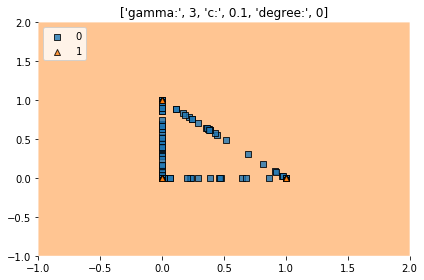

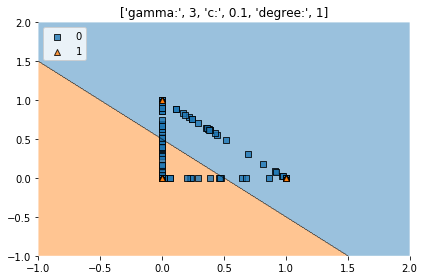

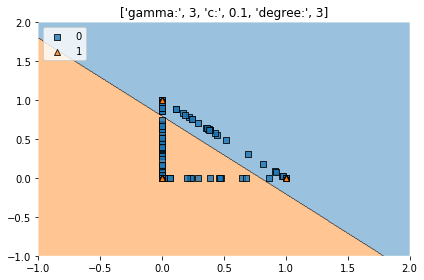

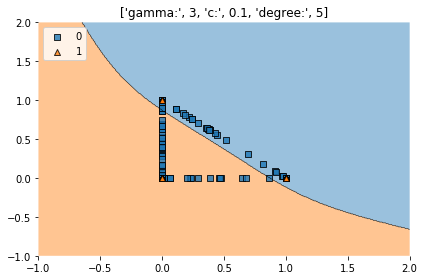

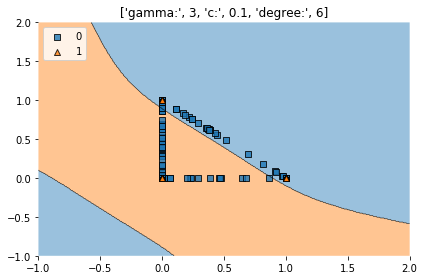

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


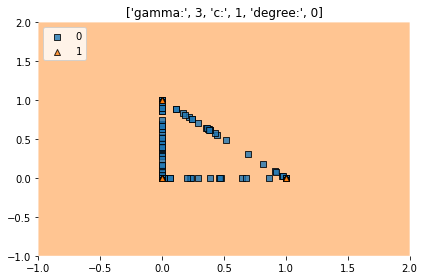

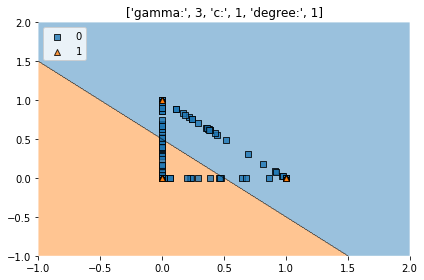

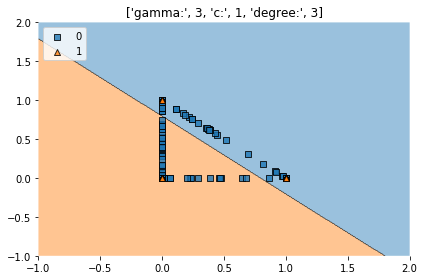

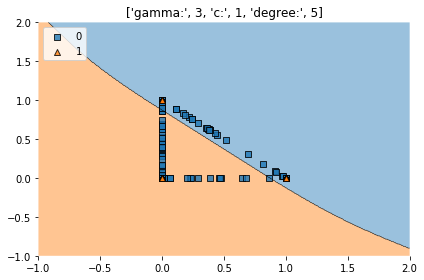

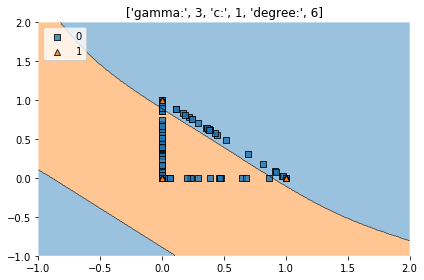

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


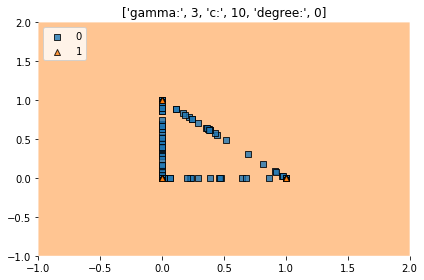

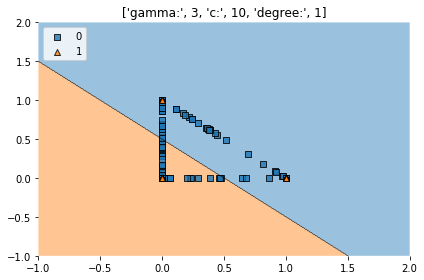

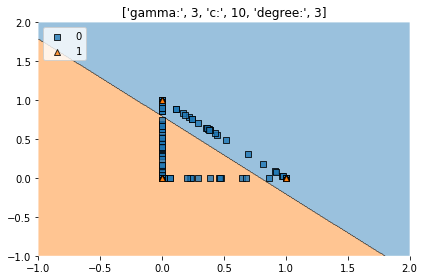

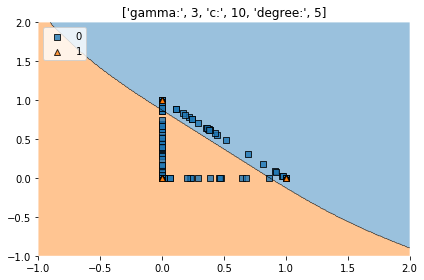

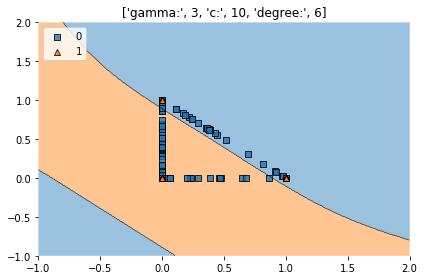

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


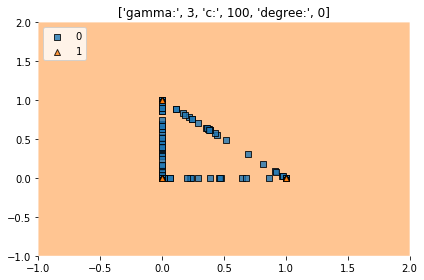

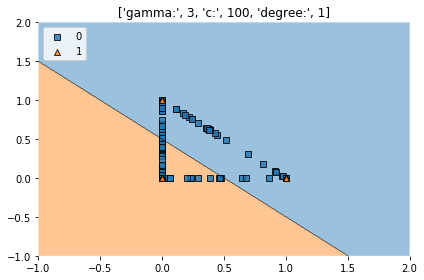

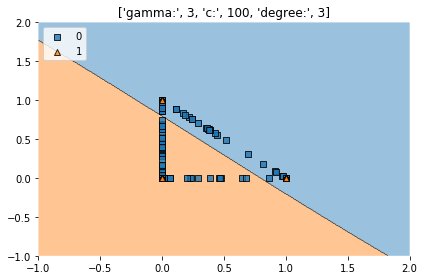

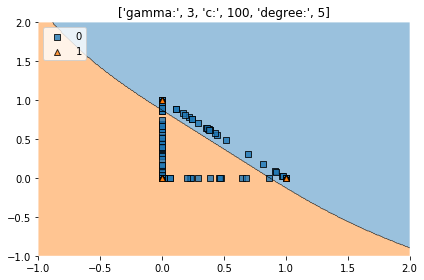

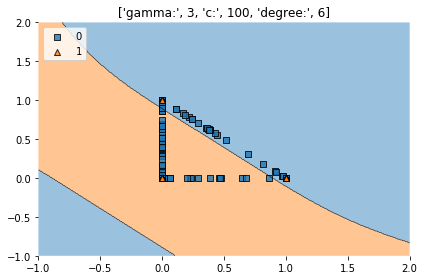

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


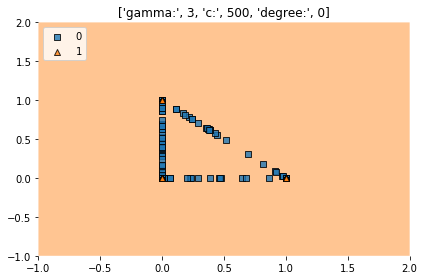

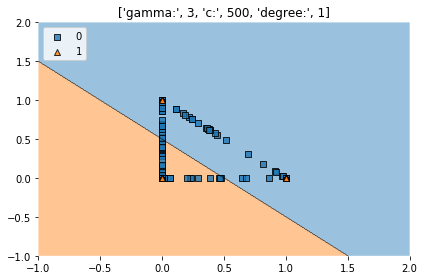

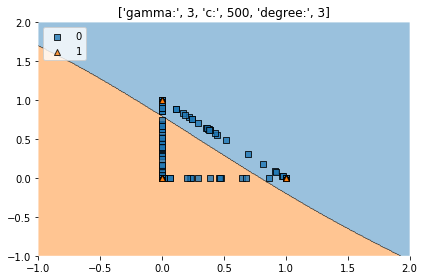

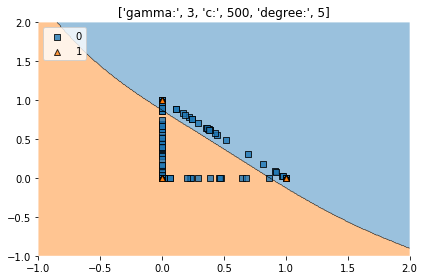

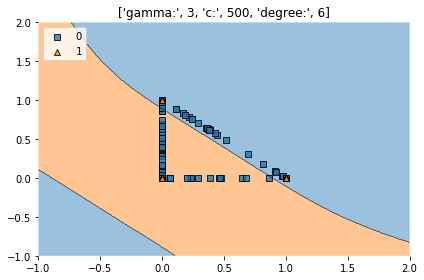

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


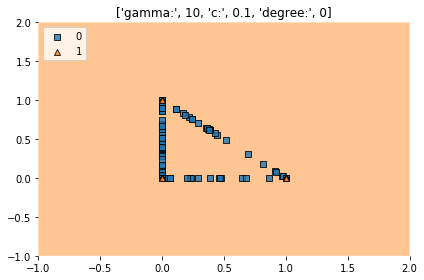

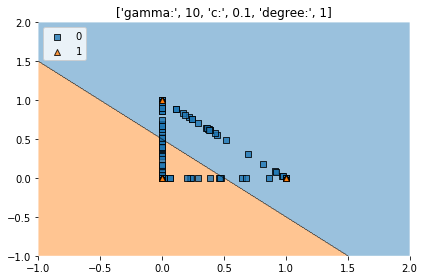

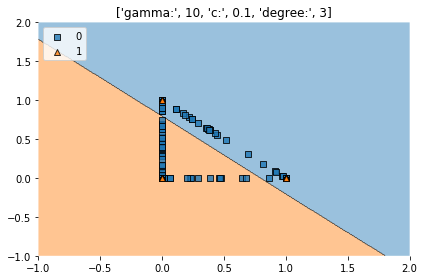

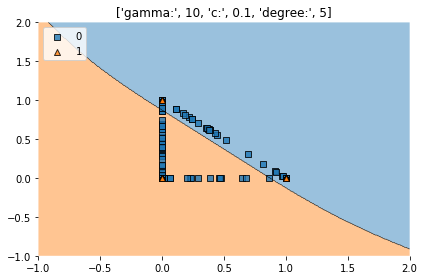

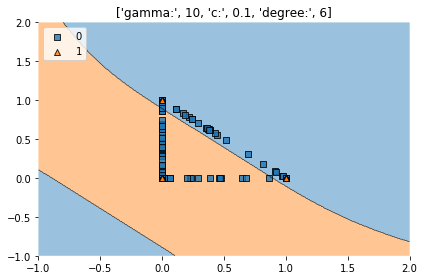

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


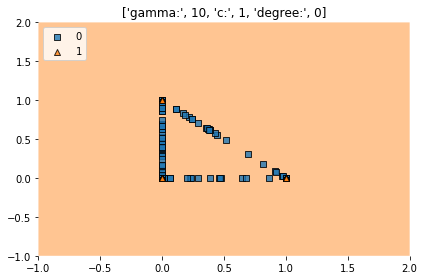

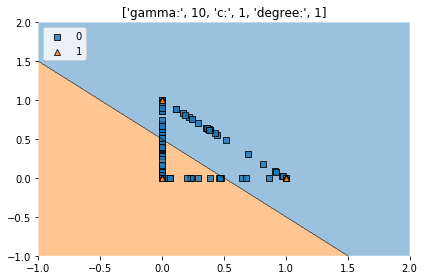

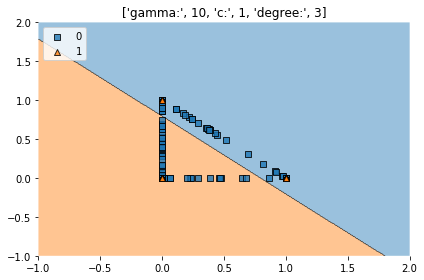

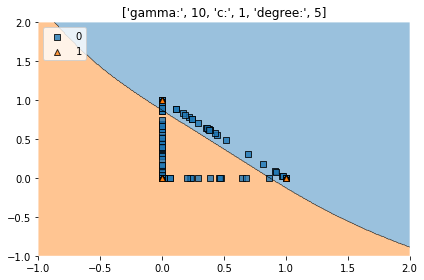

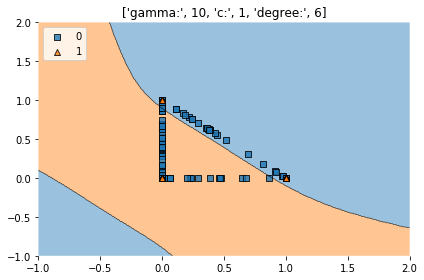

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


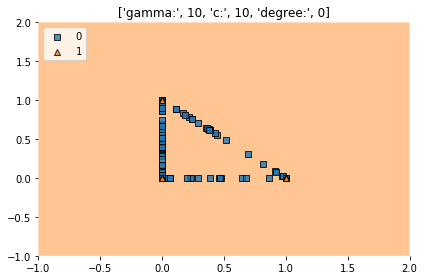

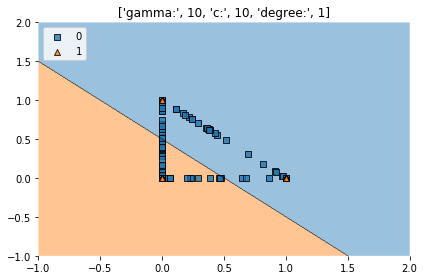

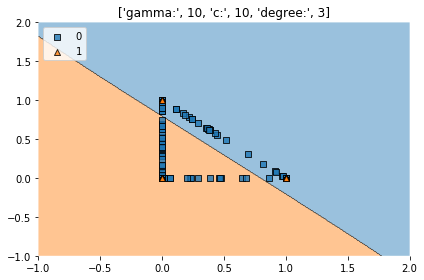

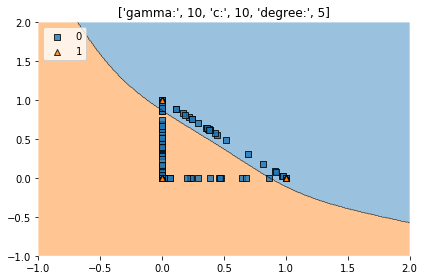

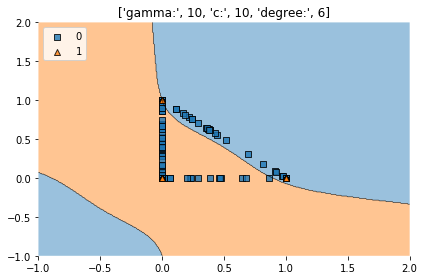

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


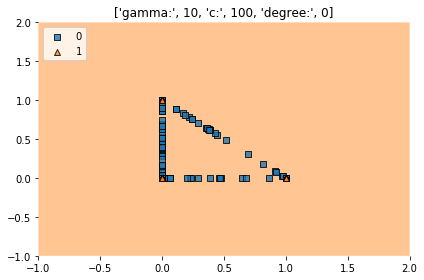

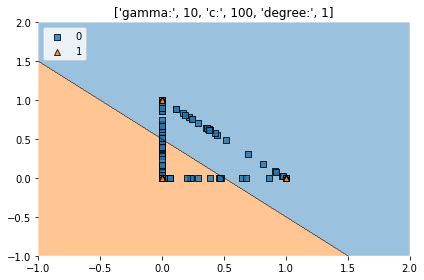

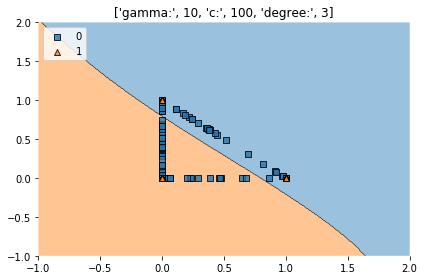

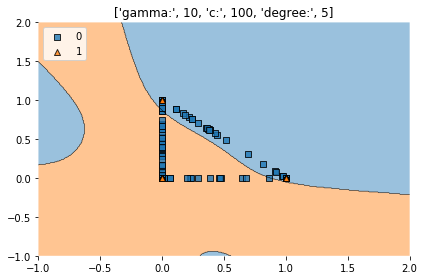

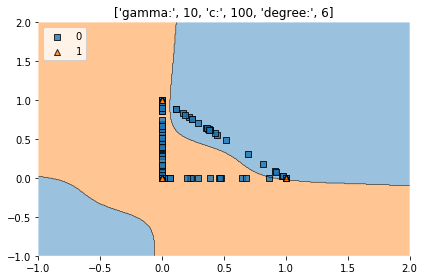

C:\Users\himaj\Anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


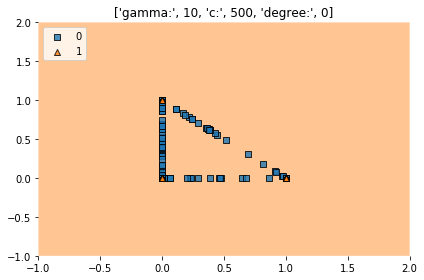

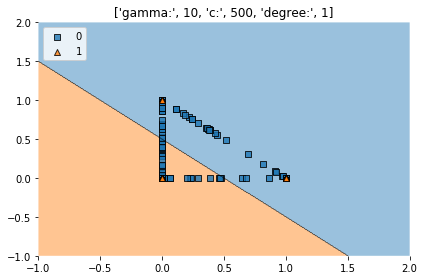

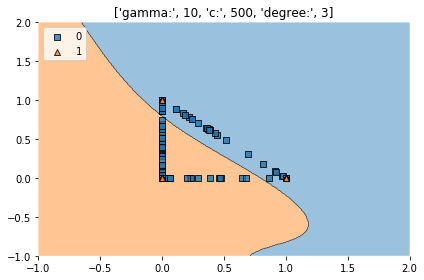

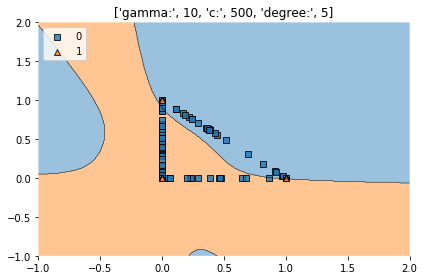

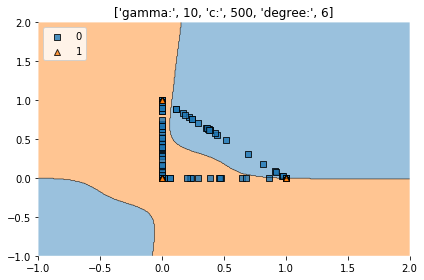

In [113]:
gammas = [0.1,1,3,10]
cs = [0.1,1,10,100,500]
degree = [0,1,3,5,6]
for gamma in gammas:
    for c in cs:
        for d in degree:
            svm = SVC(kernel='poly', random_state=0, gamma=gamma, C=c, degree=d).fit(X,y)
            plot_decision_regions(X, y, clf=svm)
            label = ['gamma:',gamma,'c:',c,'degree:',d]
            plt.title(label)
            plt.legend(loc='upper left')
            plt.tight_layout()
            plt.show()

#### Decision Tree 

#####  Decision Tree - Appliances Data 

Train Error:  0.0744172578543506
Test Error:  0.1859483195406182
CV Accuracy: 0.83 (+/- 0.01)
CV Precision: 0.82 (+/- 0.01)
CV Recall: 0.79 (+/- 0.01)
CV roc_auc: 0.88 (+/- 0.01)
[[2691  492]
 [ 609 2129]]


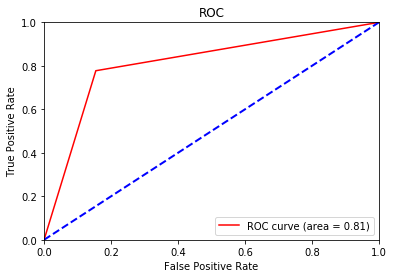

In [91]:
decision_tree(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

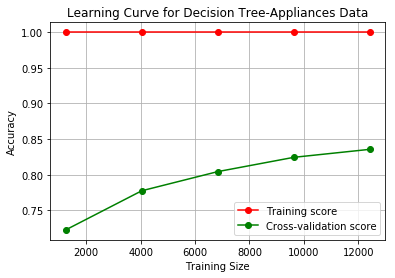

In [96]:
learning_curves(tree.DecisionTreeClassifier(criterion='gini'),'Learning Curve for Decision Tree-Appliances Data', xtrain_app_energy,ytrain_app_energy)

Train Error:  0.29433907629940637
Test Error:  0.29910488093227494
CV Accuracy: 0.70 (+/- 0.01)
CV Precision: 0.65 (+/- 0.01)
CV Recall: 0.74 (+/- 0.01)
CV roc_auc: 0.74 (+/- 0.01)
[[2145 1038]
 [ 733 2005]]


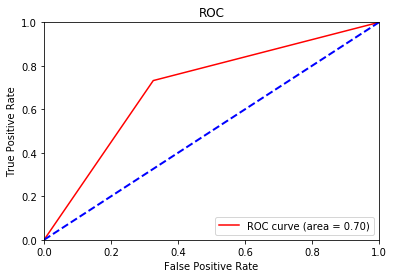

In [97]:
decision_tree_entropy(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

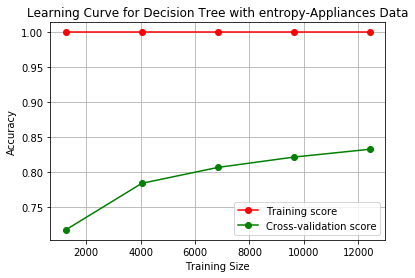

In [98]:
learning_curves(tree.DecisionTreeClassifier(criterion='entropy'),'Learning Curve for Decision Tree with entropy-Appliances Data', xtrain_app_energy,ytrain_app_energy)

#####  Decision Tree - German Credit Data 

Train Error:  0.12857142857142856
Test Error:  0.31000000000000005
CV Accuracy: 0.67 (+/- 0.07)
CV Precision: 0.75 (+/- 0.05)
CV Recall: 0.77 (+/- 0.07)
CV roc_auc: 0.63 (+/- 0.08)
[[ 43  43]
 [ 50 164]]


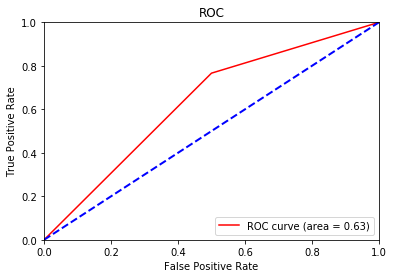

In [262]:
# Decision Tree - Unbalanced Data
decision_tree(xtrain, ytrain, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

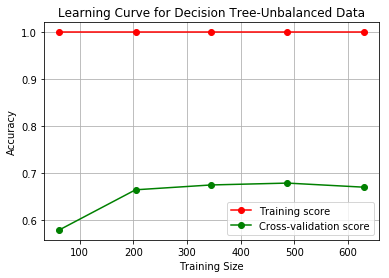

In [61]:
learning_curves(tree.DecisionTreeClassifier(),'Learning Curve for Decision Tree-Unbalanced Data', xtrain,ytrain)

Train Error:  0.0967078189300411
Test Error:  0.2666666666666667
CV Accuracy: 0.75 (+/- 0.10)
CV Precision: 0.76 (+/- 0.14)
CV Recall: 0.75 (+/- 0.07)
CV roc_auc: 0.81 (+/- 0.09)
[[ 47  39]
 [ 41 173]]


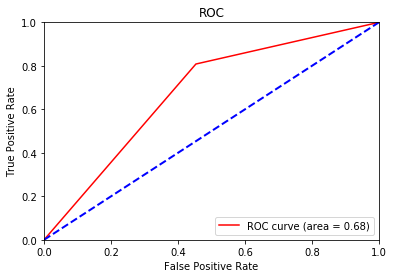

In [263]:
# Decision Tree - balanced Data
decision_tree(xtrain1, ytrain1, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

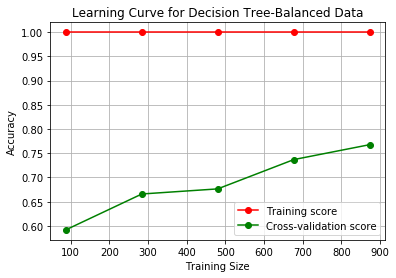

In [62]:
learning_curves(tree.DecisionTreeClassifier(),'Learning Curve for Decision Tree-Balanced Data', xtrain1,ytrain1)

Train Error:  0.28
Test Error:  0.2766666666666666
CV Accuracy: 0.69 (+/- 0.04)
CV Precision: 0.72 (+/- 0.02)
CV Recall: 0.92 (+/- 0.11)
CV roc_auc: 0.67 (+/- 0.07)
[[ 11  75]
 [  8 206]]


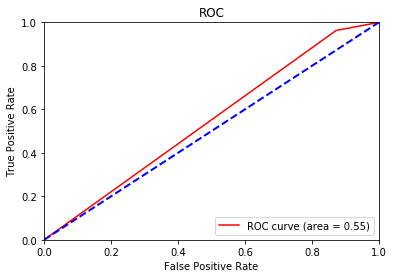

In [264]:
# Decision tree with entropy - Unbalanced Data
decision_tree_entropy(xtrain,ytrain,xtest,ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

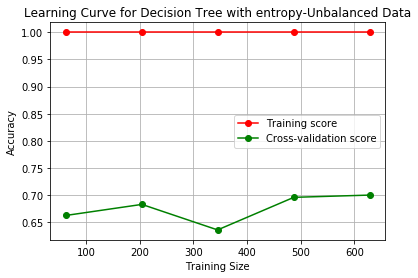

In [64]:
learning_curves(tree.DecisionTreeClassifier(criterion='entropy'),'Learning Curve for Decision Tree with entropy-Unbalanced Data', xtrain,ytrain)

Train Error:  0.24691358024691357
Test Error:  0.32333333333333336
CV Accuracy: 0.70 (+/- 0.06)
CV Precision: 0.76 (+/- 0.10)
CV Recall: 0.63 (+/- 0.14)
CV roc_auc: 0.76 (+/- 0.06)
[[ 57  29]
 [ 68 146]]


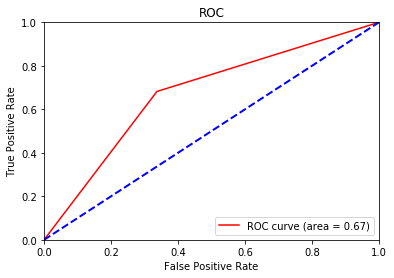

In [265]:
# Decision tree with entropy - Balanced Data
decision_tree_entropy(xtrain1,ytrain1,xtest,ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

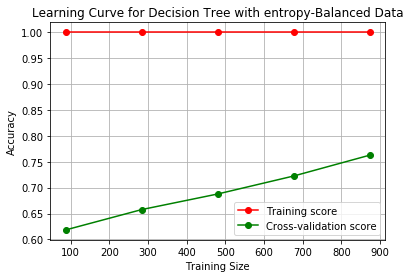

In [65]:
learning_curves(tree.DecisionTreeClassifier(criterion='entropy'),'Learning Curve for Decision Tree with entropy-Balanced Data', xtrain1,ytrain1)

#### Random Forest 

#####  Random Forest - Appliances Data 

C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Error:  0.008469668452294798
Test Error:  0.13680121601080897
CV Accuracy: 0.87 (+/- 0.01)
CV Precision: 0.87 (+/- 0.01)
CV Recall: 0.83 (+/- 0.01)
CV roc_auc: 0.93 (+/- 0.01)
[[2860  323]
 [ 487 2251]]


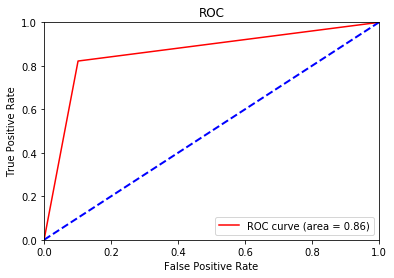

In [99]:
random_forest(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

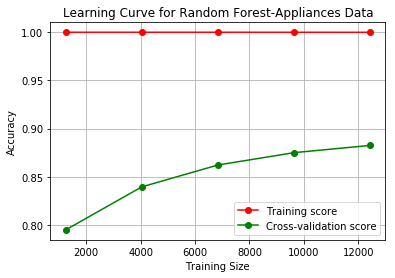

In [100]:
learning_curves(RandomForestClassifier(n_estimators=100),'Learning Curve for Random Forest-Appliances Data', xtrain_app_energy, ytrain_app_energy)

#####  Random Forest - German Credit Data 

C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Error:  0.008571428571428563
Test Error:  0.2566666666666667
CV Accuracy: 0.72 (+/- 0.05)
CV Precision: 0.79 (+/- 0.03)
CV Recall: 0.81 (+/- 0.07)
CV roc_auc: 0.73 (+/- 0.09)
[[ 51  35]
 [ 42 172]]


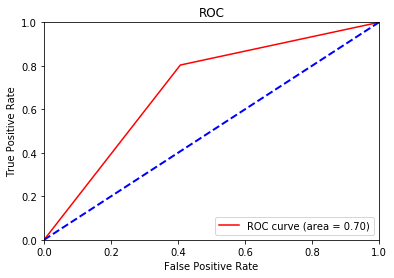

In [266]:
# Random Forest - Unbalanced Data
random_forest(xtrain, ytrain, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

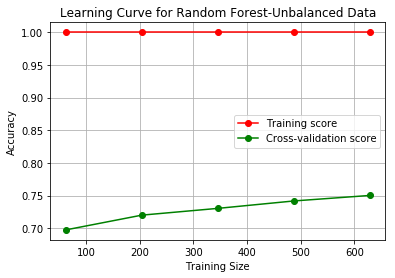

In [67]:
learning_curves(RandomForestClassifier(n_estimators=100),'Learning Curve for Random Forest-Unbalanced Data', xtrain,ytrain)

C:\Users\himaj\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Error:  0.0030864197530864335
Test Error:  0.26
CV Accuracy: 0.81 (+/- 0.08)
CV Precision: 0.85 (+/- 0.14)
CV Recall: 0.79 (+/- 0.07)
CV roc_auc: 0.91 (+/- 0.08)
[[ 56  30]
 [ 48 166]]


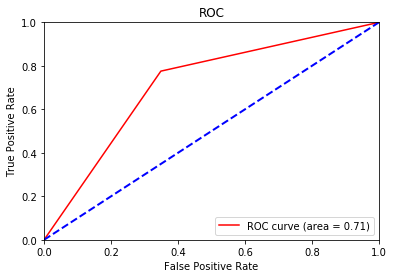

In [267]:
# Random Forest - balanced Data
random_forest(xtrain1, ytrain1, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

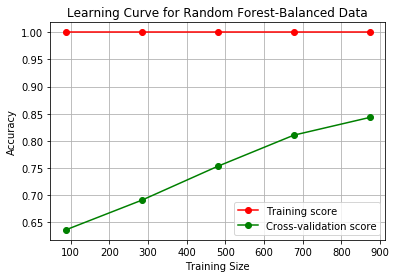

In [68]:
learning_curves(RandomForestClassifier(n_estimators=100),'Learning Curve for Random Forest-Balanced Data', xtrain1,ytrain1)

#### Gradient Boosting 

#####  Gradient Boosting - Appliances Data 

Train Error:  0.20233096858259736
Test Error:  0.23053538253673367
CV Accuracy: 0.78 (+/- 0.01)
CV Precision: 0.76 (+/- 0.01)
CV Recall: 0.74 (+/- 0.01)
CV roc_auc: 0.86 (+/- 0.01)
[[2541  642]
 [ 723 2015]]


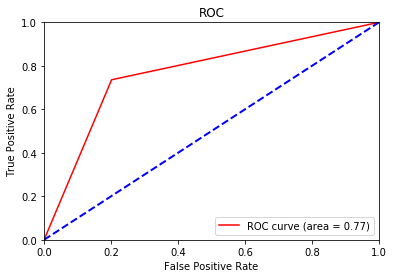

In [101]:
gradient_boosting(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

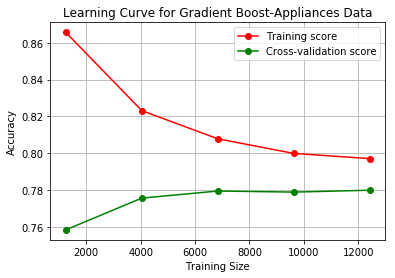

In [102]:
learning_curves(GradientBoostingClassifier(),'Learning Curve for Gradient Boost-Appliances Data', xtrain_app_energy,ytrain_app_energy)

#####  Gradient Boosting - German Credit Data 

Train Error:  0.07857142857142863
Test Error:  0.22333333333333338
CV Accuracy: 0.73 (+/- 0.05)
CV Precision: 0.77 (+/- 0.03)
CV Recall: 0.87 (+/- 0.06)
CV roc_auc: 0.77 (+/- 0.08)
[[ 43  43]
 [ 24 190]]


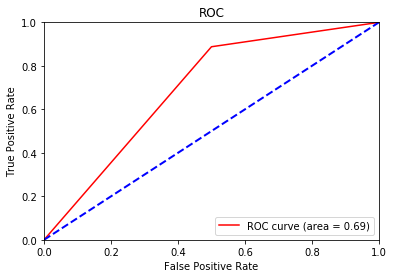

In [268]:
# Gradient Boosting - Unbalanced Data
gradient_boosting(xtrain, ytrain, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

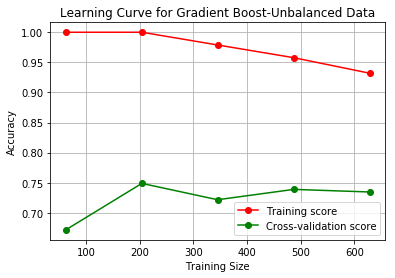

In [69]:
learning_curves(GradientBoostingClassifier(),'Learning Curve for Gradient Boost-Unbalanced Data', xtrain,ytrain)

Train Error:  0.07098765432098764
Test Error:  0.2366666666666667
CV Accuracy: 0.82 (+/- 0.10)
CV Precision: 0.85 (+/- 0.15)
CV Recall: 0.82 (+/- 0.09)
CV roc_auc: 0.91 (+/- 0.09)
[[ 51  35]
 [ 36 178]]


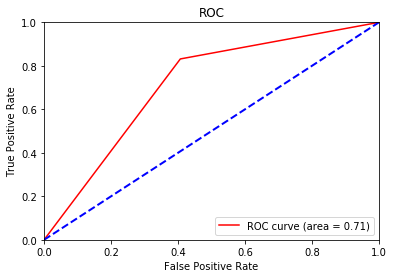

In [269]:
# Gradient Boosting - balanced Data
gradient_boosting(xtrain1, ytrain1, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

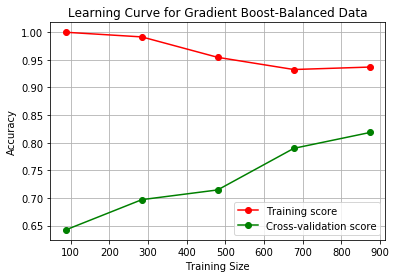

In [70]:
learning_curves(GradientBoostingClassifier(),'Learning Curve for Gradient Boost-Balanced Data', xtrain1,ytrain1)

#### AdaBoost 

#####  AdaBoost - Appliances Data 

Train Error:  0.2416389170406834
Test Error:  0.26009120081067383
CV Accuracy: 0.75 (+/- 0.01)
CV Precision: 0.74 (+/- 0.01)
CV Recall: 0.69 (+/- 0.02)
CV roc_auc: 0.82 (+/- 0.01)
[[2544  639]
 [ 901 1837]]


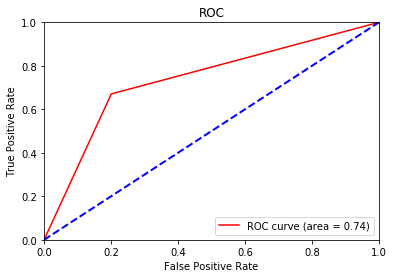

In [103]:
ada_boost(xtrain_app_energy, ytrain_app_energy, xtest_app_energy, ytest_app_energy)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

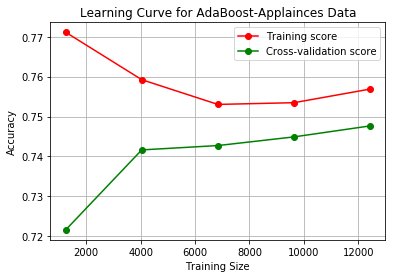

In [104]:
learning_curves(AdaBoostClassifier(),'Learning Curve for AdaBoost-Applainces Data', xtrain_app_energy,ytrain_app_energy)

#####  AdaBoost - German Credit Data 

Train Error:  0.19571428571428573
Test Error:  0.2366666666666667
CV Accuracy: 0.73 (+/- 0.06)
CV Precision: 0.79 (+/- 0.04)
CV Recall: 0.83 (+/- 0.08)
CV roc_auc: 0.76 (+/- 0.08)
[[ 48  38]
 [ 33 181]]


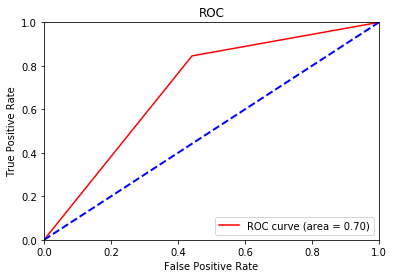

In [270]:
# Adaboost - Unbalanced Data
ada_boost(xtrain, ytrain, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

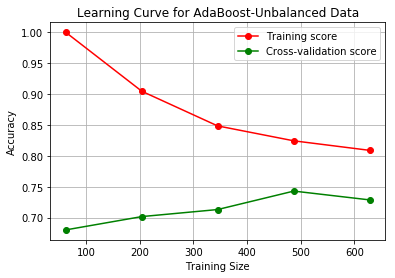

In [71]:
learning_curves(AdaBoostClassifier(),'Learning Curve for AdaBoost-Unbalanced Data', xtrain,ytrain)

Train Error:  0.15637860082304522
Test Error:  0.2533333333333333
CV Accuracy: 0.79 (+/- 0.10)
CV Precision: 0.82 (+/- 0.14)
CV Recall: 0.78 (+/- 0.09)
CV roc_auc: 0.88 (+/- 0.09)
[[ 53  33]
 [ 43 171]]


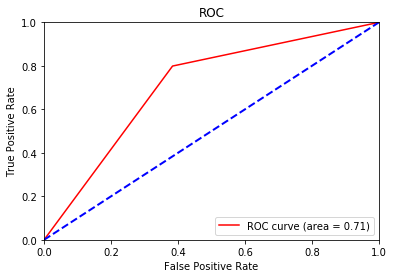

In [271]:
# Adaboost - Balanced Data
ada_boost(xtrain1, ytrain1, xtest, ytest)

<module 'matplotlib.pyplot' from 'C:\\Users\\himaj\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

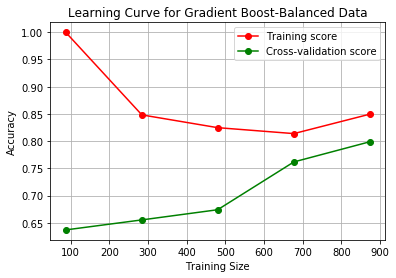

In [72]:
learning_curves(AdaBoostClassifier(),'Learning Curve for Gradient Boost-Balanced Data', xtrain1,ytrain1)